# new RNN

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import seaborn as sns
import random 
import sys
from preprocessing import merge_dataset
# Load the NetCDF file
#nc_file = 'data/derivatives/dataset_MOTOR_60_subjects_both.nc' # hrf convoluted + block, if we want to denoise data
nc_file = 'data/derivatives/dataset_MOTOR_60_subjects_both_noncens.nc'
merged = merge_dataset([
    xr.load_dataset("/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/dataset_LANGUAGE_1_subjects_normed.nc"),
    xr.load_dataset("/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/dataset_EMOTION_1_subjects_normed.nc"),
    xr.load_dataset("/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/dataset_WM_1_subjects_normed.nc"),
    xr.load_dataset("/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/dataset_RELATIONAL_1_subjects_normed.nc"),
])
np.random.seed(459345)
dataset = xr.open_dataset(nc_file)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

TR=0.72

# Print dataset to inspect the contents
print(dataset)



/media/RCPNAS/Data2/CS-433-ML4S/preprocessing.py:223: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  max_len = max(ds.dims['time'] for ds in datasets)
/media/RCPNAS/Data2/CS-433-ML4S/preprocessing.py:227: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(ds.dims['time'], ds.task.item())
/media/RCPNAS/Data2/CS-433-ML4S/preprocessing.py:228: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  curr_

316 LANGUAGE
176 EMOTION
405 WM
232 RELATIONAL
<xarray.Dataset> Size: 813MB
Dimensions:  (subject: 60, voxel: 1989, time: 284)
Coordinates:
  * voxel    (voxel) int64 16kB 0 1 2 3 4 5 6 ... 1983 1984 1985 1986 1987 1988
  * time     (time) int64 2kB 0 1 2 3 4 5 6 7 ... 277 278 279 280 281 282 283
  * subject  (subject) <U9 2kB '118932_RL' '113619_LR' ... '148335_LR'
    task     <U5 20B ...
Data variables:
    X        (subject, voxel, time) float64 271MB ...
    Y        (subject, voxel, time) float64 271MB ...
    Y_conv   (subject, voxel, time) float64 271MB ...
Attributes:
    description:  Dataset for subject 118932, task MOTOR, acquisition RL


In [2]:
def scramble_blocks(tensor, block_size):
    """
    Scrambles the timepoints in the tensor by swapping two blocks of the given size.

    Parameters:
    - tensor: A tensor of shape (n_samples, n_timepoints)
    - block_size: The size of the blocks to swap

    Returns:
    - A tensor with scrambled blocks
    """
    n_samples, n_timepoints = tensor.shape
    
    if block_size * 2 > n_timepoints:
        raise ValueError("Block size is too large for the number of timepoints.")

    # Randomly select two block start indices
    idx1 = torch.randint(0, n_timepoints - block_size + 1, (1,)).item()
    idx2 = torch.randint(0, n_timepoints - block_size + 1, (1,)).item()

    # Ensure the two indices are distinct
    while abs(idx1 - idx2) < block_size:
        idx2 = torch.randint(0, n_timepoints - block_size + 1, (1,)).item()

    # Extract blocks
    block1 = tensor[:, idx1:idx1 + block_size]
    block2 = tensor[:, idx2:idx2 + block_size]

    # Create scrambled tensor
    scrambled = tensor.clone()  # Clone the input tensor to preserve original data
    scrambled[:, idx1:idx1 + block_size] = block2
    scrambled[:, idx2:idx2 + block_size] = block1

    return scrambled, (idx1, idx2)


In [3]:
def temporal_scale(X, y, scale_range=(0.8, 1.2), ratio=0.3, keep_len=True):
    n_voxels, time_points, _ = X.shape
    
    if not keep_len:
        new_length = int(time_points * np.random.uniform(*scale_range))
        print("new_length", new_length)
        scaled_X = torch.nn.functional.interpolate(X.transpose(1,2), size=new_length).transpose(1,2)
        scaled_y = torch.nn.functional.interpolate(y.unsqueeze(1), size=new_length).squeeze(1)
    else:
        scaled_X, scaled_y = X.clone(), y.clone()
    
    for vox_idx in np.random.choice(range(n_voxels), size=int(n_voxels * ratio), replace=False):
        new_length = int(time_points * np.random.uniform(*scale_range)) if keep_len else scaled_X.shape[1]
        x_interp = torch.nn.functional.interpolate(X[vox_idx].T.unsqueeze(0), size=new_length).squeeze().T.unsqueeze(-1)
        y_interp = torch.nn.functional.interpolate(y[vox_idx].unsqueeze(0).unsqueeze(0), size=new_length).squeeze()
        
        if keep_len:
            if new_length < time_points:
                repeats = int(np.ceil(time_points / new_length))
                x_interp = x_interp.repeat(repeats, 1)[:time_points]
                y_interp = y_interp.repeat(repeats)[:time_points]
            else:
                x_interp = x_interp[:time_points]  # Only trim if longer
                y_interp = y_interp[:time_points]
            scaled_X[vox_idx] = x_interp
            scaled_y[vox_idx] = y_interp
        else:
            scaled_X[vox_idx] = x_interp
            scaled_y[vox_idx] = y_interp
            
    return scaled_X, scaled_y


def augment_data(X_train, Y_train, shift_range=(-20, +20), amplitude_range=(0.5, 2), noise_std=0.1, stretch_ratio=0.6,plot_times=False):
    """
    Augment the data by shifting and scaling the time series data.
    
    Parameters:
    - X_train, Y_train Tensors for the BOLD signal and predicted signals (Y).
    - shift_range: Tuple defining the range for temporal shifts (in number of time steps).
    - amplitude_range: Tuple defining the range for amplitude scaling (scaling factor).
    
    Returns:
    - Augmented tensors for X, Y
    """
    print("Data augmentation")
    # Apply time shifts and amplitude scaling to the training set
    augmented_X = []
    augmented_Y = []
    num_samples = X_train.shape[0]
    if plot_times:
        x,y = X_train[0,:],Y_train[0,:]
        plt.plot(x,label="original")
        plt.plot(y,label='block')
        plt.legend()
        plt.show()

    for i in range(num_samples):
        # 1. Apply random time shift
        shift = np.random.randint(shift_range[0], shift_range[1] + 1)
        shifted_X = torch.roll(X_train[i], shifts=shift, dims=0)
        shifted_Y = torch.roll(Y_train[i], shifts=shift, dims=0)
        if plot_times:

            x,y = shifted_X,shifted_Y
            plt.plot(x,label="original")
            plt.plot(y,label='block')
            plt.legend()
            plt.show()
        

        # 2. Apply random amplitude scaling
        scale_factor = np.random.uniform(amplitude_range[0], amplitude_range[1])
        scaled_X = shifted_X * scale_factor
        scaled_Y = shifted_Y * scale_factor
        if plot_times:

            x,y = scaled_X,scaled_Y
            plt.plot(x,label="original")
            plt.plot(y,label='block')
            plt.legend()
            plt.show()
                
        # 4. Add Gaussian noise
        noise_std_value = noise_std*torch.max(scaled_Y).item()
        noise_X = torch.normal(mean=0, std=noise_std_value, size=scaled_X.shape, device=scaled_X.device)
        noisy_X = scaled_X + noise_X
        if plot_times:

            x,y = noisy_X,scaled_Y
            plt.plot(x,label="original")
            plt.plot(y,label='block')
            plt.legend()
            plt.show()
            plot_times-=1
        # Store augmented samples
        augmented_X.append(noisy_X)
        augmented_Y.append(scaled_Y)

    # Convert lists back to tensors
    augmented_X_tensor = torch.stack(augmented_X)
    augmented_Y_tensor = torch.stack(augmented_Y)
    
    return augmented_X_tensor, augmented_Y_tensor


def preprocess_subject_data(subject_data):
    """
    Preprocess the data for a given subject, including normalization, 
    handling missing values, and applying temporal shifts.

    Parameters:
    - subject_data: The data for a single subject.

    Returns:
    - X_tensor, Y_tensor: Preprocessed tensors for the BOLD signal and predicted signals.
    """
    print("Data preprocess")
    
    X_subject = subject_data['X']  # Shape: [voxels, time]
    Y_subject = subject_data['Y']  # Shape: [voxels, time]

    # Access time series for all voxels
    X_vals = X_subject.values
    Y_vals = Y_subject.values

    # Remove rows with NaNs in any voxel time series
    print("Remove rows with NaNs in any voxel time series")
    valid_mask = ~np.isnan(X_vals).any(axis=1)
    X_vals = X_vals[valid_mask]
    Y_vals = Y_vals[valid_mask]

    # Normalize BOLD signal (X)
    print("Normalize BOLD signal (X)")
    X_vals = (X_vals - np.mean(X_vals, axis=1, keepdims=True)) / np.std(X_vals, axis=1, keepdims=True)
    Y_vals = (Y_vals - np.mean(Y_vals, axis=1, keepdims=True)) / np.std(Y_vals, axis=1, keepdims=True)

    # Convert to PyTorch tensors
    print("Convert to PyTorch tensors")
    X_tensor = torch.tensor(X_vals, dtype=torch.float32)
    Y_tensor = torch.tensor(Y_vals, dtype=torch.float32)

    return X_tensor, Y_tensor

    #reversed_X_train = torch.flip(X_tensor, dims=[1])
    #reversed_Y_train = torch.flip(Y_tensor, dims=[1])

    #return reversed_X_train, reversed_Y_train


def concat_data(all_X_train, all_X_val, all_X_test, all_Y_train, all_Y_val, all_Y_test):
    """
    Concatenate the data from all subjects into one large dataset.

    Parameters:
    - all_X_train: List of tensors, each containing training data for a subject.
    - all_X_val: List of tensors, each containing validation data for a subject.
    - all_X_test: List of tensors, each containing test data for a subject.
    - all_Y_train: List of tensors, each containing labels for a subject.
    - all_Y_val: List of tensors, each containing labels for a subject.
    - all_Y_test: List of tensors, each containing labels for a subject.

    Returns:
    - Concatenated tensors for training, validation, and test sets.
    """

    # Concatenate lists into tensors
    X_train_def = torch.cat(all_X_train, dim=0)
    X_val_def = torch.cat(all_X_val, dim=0)
    X_test_def = torch.cat(all_X_test, dim=0).unsqueeze(-1)
    Y_train_def = torch.cat(all_Y_train, dim=0).unsqueeze(-1)
    Y_val_def = torch.cat(all_Y_val, dim=0).unsqueeze(-1)
    Y_test_def = torch.cat(all_Y_test, dim=0).unsqueeze(-1)

    return X_train_def, X_val_def, X_test_def, Y_train_def, Y_val_def, Y_test_def



In [4]:
def custom_progress_bar(current, total, description="Processing"):
    percent = int((current / total) * 100)
    bar = f"[{'#' * (percent // 2)}{'-' * (50 - percent // 2)}] {percent}%"
    sys.stdout.write(f"\r{description}: {bar}")
    sys.stdout.flush()
def get_data_tensors(subject_ids):

    # Shuffle subject IDs
    random.seed(42)  # Set seed for reproducibility
    shuffled_subjects = subject_ids.copy()
    random.shuffle(shuffled_subjects)
    
    # Compute split indices based on percentages
    total_subjects = len(shuffled_subjects)
    train_end = int(0.6 * total_subjects)
    val_end = int(0.8 * total_subjects)
    
    # Split subjects into train, val, and test
    train_subjects = shuffled_subjects[:train_end]
    val_subjects = shuffled_subjects[train_end:val_end]
    test_subjects = shuffled_subjects[val_end:]

    all_X_train, all_X_val, all_X_test = [], [], []
    all_Y_train, all_Y_val, all_Y_test = [], [], []
    print("\nProcessing Train Subjects:")

    # Process train subjects
    for idx, train_subj in enumerate(train_subjects, 1):
        subject_data = dataset.sel(subject=train_subj)  # Extract subject data
        X_train_tensor, Y_train_tensor = preprocess_subject_data(subject_data)
        # Augment training data
        X_train_aug, Y_train_aug = augment_data(X_train_tensor, Y_train_tensor)
        # Apply temporal scaling to the augmented data
        X_train_aug, Y_train_aug = temporal_scale(X_train_aug.unsqueeze(-1), Y_train_aug)
        all_X_train.append(X_train_aug)
        all_Y_train.append(Y_train_aug)
        custom_progress_bar(idx, len(train_subjects))

    print("\nProcessing Validation Subjects:")
    for idx, val_subj in enumerate(val_subjects, 1):
        subject_data = dataset.sel(subject=val_subj)  # Extract subject data
        X_val_tensor, Y_val_tensor = preprocess_subject_data(subject_data)
        # Augment training data
        X_val_aug, Y_val_aug = augment_data(X_val_tensor, Y_val_tensor)
        # Apply temporal scaling to the augmented data
        X_val_aug, Y_val_aug = temporal_scale(X_val_aug.unsqueeze(-1), Y_val_aug)
        all_X_val.append(X_val_aug)
        all_Y_val.append(Y_val_aug)
        custom_progress_bar(idx, len(val_subjects))

    print("\nProcessing Test Subjects:")
    for idx, test_subj in enumerate(test_subjects, 1):
        subject_data = dataset.sel(subject=test_subj)  # Extract subject data
        X_test_tensor, Y_test_tensor = preprocess_subject_data(subject_data)
        all_X_test.append(X_test_tensor)
        all_Y_test.append(Y_test_tensor)
        custom_progress_bar(idx, len(test_subjects))

    # Concatenate data for all subjects
    X_train_def, X_val_def, X_test_def,Y_train_def, Y_val_def ,Y_test_def = concat_data(
        all_X_train, all_X_val, all_X_test, all_Y_train, all_Y_val, all_Y_test)
    print()
    print("X_train",X_train_def.shape)
    print("X_val",X_val_def.shape)
    print("X_test",X_test_def.shape)
    print("Y_train",Y_train_def.shape)
    print("Y_val",Y_val_def.shape)
    print("Y_test",Y_test_def.shape)

    return X_train_def, Y_train_def, X_test_def, Y_test_def, X_val_def, Y_val_def


In [5]:
subjects_ids = dataset.subject.values

X_train_def, Y_train_def, X_test_def, Y_test_def, X_val_def, Y_val_def = get_data_tensors(subjects_ids)



Processing Train Subjects:
Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Data augmentation
Processing: [#-------------------------------------------------] 2%

/tmp/ipykernel_651520/3633084129.py:14: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1728945370933/work/aten/src/ATen/native/TensorShape.cpp:3683.)
  x_interp = torch.nn.functional.interpolate(X[vox_idx].T.unsqueeze(0), size=new_length).squeeze().T.unsqueeze(-1)


Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Data augmentation
Processing: [##------------------------------------------------] 5%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Data augmentation
Processing: [####----------------------------------------------] 8%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Data augmentation
Processing: [#####---------------------------------------------] 11%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Data augmentation
Processing: [######--------------------------------------------] 13%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Data augmentation
Processing: [########---------------------------------------

Processing: [#########################-------------------------] 50%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Data augmentation
Processing: [#############################---------------------] 58%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Data augmentation
Processing: [#################################-----------------] 66%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Data augmentation
Processing: [#####################################-------------] 75%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Data augmentation
Processing: [#########################################---------] 83%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Data aug

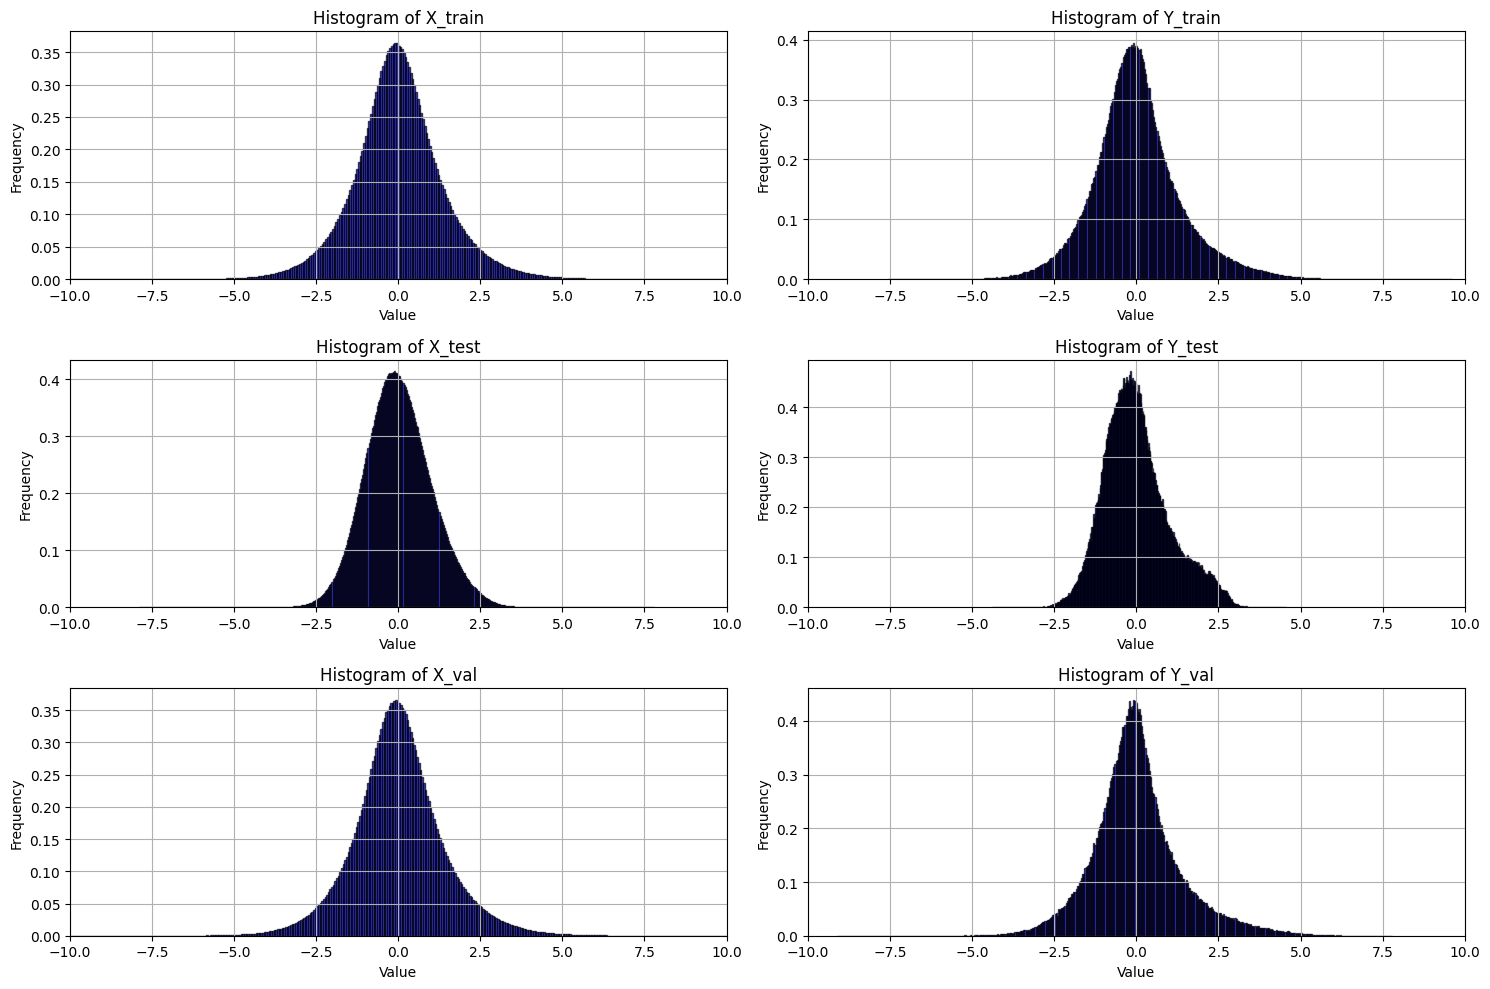

In [6]:
# List of tensors and their names
tensors = {
    "X_train": X_train_def,
    "Y_train": Y_train_def,
    "X_test": X_test_def,
    "Y_test": Y_test_def,
    "X_val": X_val_def,
    "Y_val": Y_val_def,
}

# Plot histograms for each tensor
plt.figure(figsize=(15, 10))  # Adjust figure size for better layout
for i, (name, tensor) in enumerate(tensors.items(), 1):
    flattened_values = tensor.flatten().cpu().numpy()  # Flatten and convert to numpy
    plt.subplot(3, 2, i)  # Create a subplot (3 rows, 2 columns)
    plt.hist(flattened_values, bins=500, alpha=0.7, color='blue', edgecolor='black',density=True)
    plt.title(f"Histogram of {name}")
    plt.xlabel("Value")
    plt.xlim(-10,10)
    plt.ylabel("Frequency")
    plt.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [7]:
print(X_train_def.shape)

torch.Size([69456, 284, 1])


X_train_def shape: torch.Size([69456, 284, 1]) 
Y_train_def shape: torch.Size([69456, 284, 1])


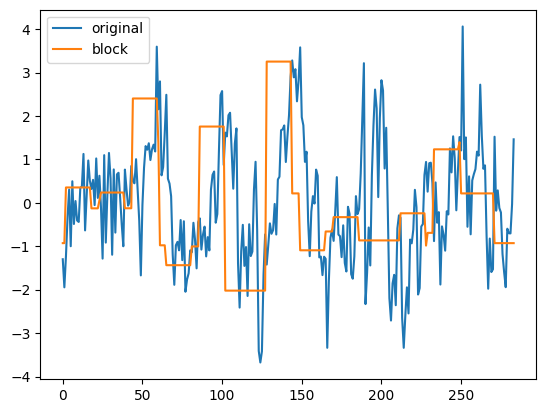

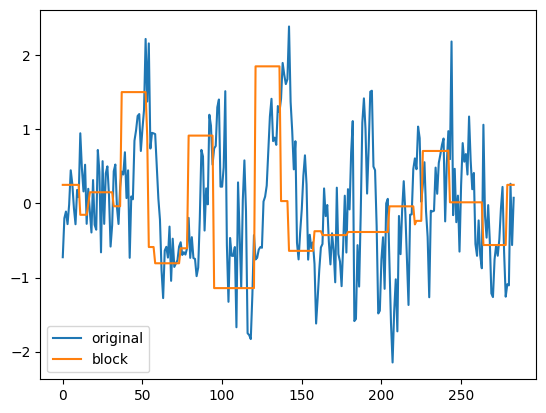

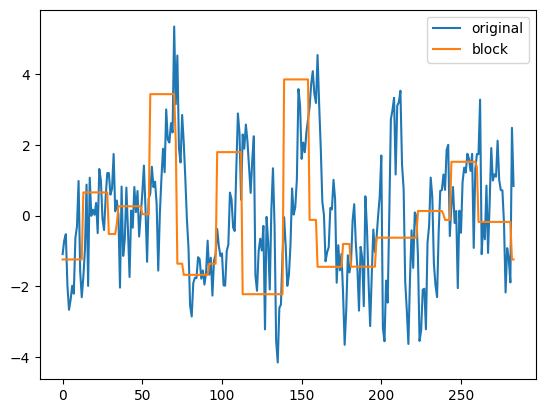

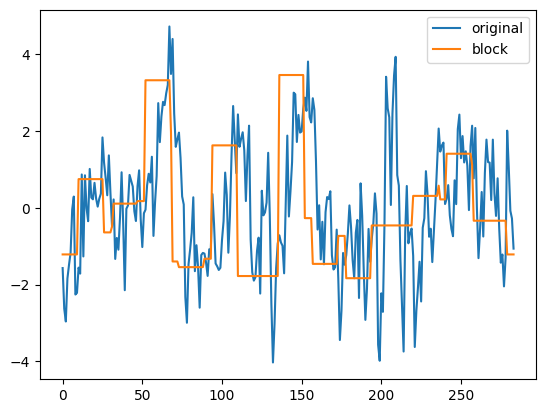

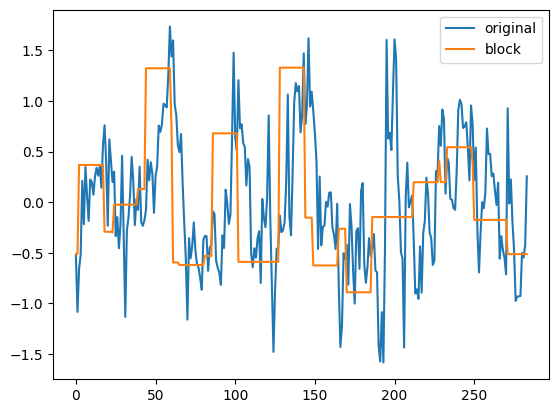

In [8]:
import matplotlib.pyplot as plt
print(f"X_train_def shape: {X_train_def.shape} \nY_train_def shape: {Y_train_def.shape}")

#X_train_def = apply_lowpass_filter(X_train_def)

for i in range (5):
    x,y = X_train_def[i,:],Y_train_def[i,:]
    plt.plot(x,label="original")
    plt.plot(y,label='block')
    plt.legend()
    plt.show()

In [9]:
#print(torch.cuda.is_available())
#print(torch.version.cuda)
#print(torch.backends.cudnn.enabled)
#print(torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.set_device(2)  # Set device to cuda:2

curr_dev=torch.cuda.current_device()
#print(curr_dev)

#print(device)

#print(torch.cuda.device(curr_dev))

#print(torch.cuda.get_device_name(curr_dev))

In [10]:
# ***************************************************
#                         MODELS
# ***************************************************

import torch
import torch.nn as nn


# LSTM CLASSIC

#class RNNModel(nn.Module):
#    def __init__(self, input_size, hidden_size, output_size):
#        super(RNNModel, self).__init__()
#        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True,num_layers=2) # Either GRU or LSTM
#        self.fc = nn.Linear(hidden_size, output_size)  # Maps hidden state to output
#
#    def forward(self, x):
#        # Pass through RNN
#        rnn_out, _ = self.rnn(x)  # rnn_out: (batch_size, seq_len, hidden_size)
#        
#        # Apply fully connected layer
#        output = self.fc(rnn_out)  # output: (batch_size, seq_len, output_size)
#        return output
#



# CONV + LSTM

#class RNNModel(nn.Module):
#   def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
#       super(RNNModel, self).__init__()
#        # 1D Convolutional Layer
#       self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size=3, padding=1)
#       self.pool = nn.MaxPool1d(kernel_size=1)
#       
#       # RNN Layer (LSTM or GRU)
#       self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=2, dropout=dropout_prob)
#       
#       # Fully connected layer
#       self.fc = nn.Linear(hidden_size, output_size)
#
#   def forward(self, x):
#       # Pass through CNN
#       x = x.permute(0, 2, 1)  # Change shape to (batch_size, channels, seq_len)
#       x = F.relu(self.conv1(x))
#       x = self.pool(x)
#       
#       # Reshape for RNN input
#       x = x.permute(0, 2, 1)  # (batch_size, seq_len, channels)
#       
#       # Pass through RNN
#       rnn_out, _ = self.rnn(x)
#       
#       # Pass the RNN output (all time steps) through the FC layer
#       output = self.fc(rnn_out)  # (batch_size, seq_len, output_size)
#       return output



#FLAVIA
## LSTM + CONV 
## RNN for Kernel Prediction
#class KernelRNN(nn.Module):
#    def __init__(self, input_dim, hidden_dim, output_dim):
#        super(KernelRNN, self).__init__()
#        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
#        self.fc = nn.Linear(hidden_dim, output_dim)  # Output should match the sequence length of target
#
#    def forward(self, y):
#        # y: [batch_size, time_steps, input_dim]
#        rnn_out, _ = self.rnn(y)  # RNN output: [batch_size, time_steps, hidden_dim]
#        print(f"RNN output shape: {rnn_out.shape}")  # Debugging the RNN output shape
#        kernel = self.fc(rnn_out)  # Output size [batch_size, time_steps, output_dim]
#        print(f"Kernel shape after FC: {kernel.shape}")  # Debugging the kernel shape
#        return kernel  # Output shape [batch_size, time_steps, output_dim]
#
#class DeconvolutionCNN(nn.Module):
#    def __init__(self, kernel_size):
#        super(DeconvolutionCNN, self).__init__()
#        # Make sure kernel size and input channels match
#        self.conv1d = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=kernel_size, padding='same', bias=False)
#
#    def forward(self, y, kernel):
#        # Ensure kernel shape is [1, 1, kernel_size] for Conv1d
#        kernel = kernel.permute(0, 2, 1)  # Convert shape to [batch_size, 1, kernel_size]
#        self.conv1d.weight.data = kernel.squeeze(1)  # kernel shape: [1, kernel_size]
#
#        # Debugging: Print the shape of y before and after permuting
#        print(f"y shape before permute: {y.shape}")  # [batch_size, sequence_length, channels]
#        y = y.permute(0, 2, 1)  # From [batch_size, sequence_length, channels] to [batch_size, 1, sequence_length]
#        print(f"y shape after permute: {y.shape}")  # [batch_size, 1, sequence_length]
#
#        # Apply deconvolution (1D convolution)
#        x_hat = self.conv1d(y)  # Apply the convolution
#        print(f"x_hat shape after Conv1d: {x_hat.shape}")  # Check output shape after Conv1d
#        return x_hat
#
#
#class RNNCNNDeconvolution(nn.Module):
#    def __init__(self, input_dim, hidden_dim, kernel_size):
#        super(RNNCNNDeconvolution, self).__init__()
#        self.kernel_rnn = KernelRNN(input_dim, hidden_dim, kernel_size)
#        self.deconv_cnn = DeconvolutionCNN(kernel_size)
#
#    def forward(self, y):
#        kernel = self.kernel_rnn(y)
#        print(f"Kernel shape from RNN: {kernel.shape}")  # Debugging the kernel shape
#        x_hat = self.deconv_cnn(y, kernel)
#        print(f"x_hat shape after deconvolution: {x_hat.shape}")  # Debugging the output shape after deconvolution
#        return x_hat
#

# FLAVIA REVISITED

#class RNNModel(nn.Module):
#    def __init__(self, input_size, hidden_size, output_size, conv_kernel_size=3, conv_out_channels=64):
#        super(RNNModel, self).__init__()
#        
#        # LSTM layer
#        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2)
#        
#        # Convolutional layer after LSTM
#        self.conv1d = nn.Conv1d(in_channels=hidden_size, out_channels=conv_out_channels, kernel_size=conv_kernel_size, padding=conv_kernel_size//2)
#        
#        # Fully connected layer
#        self.fc = nn.Linear(conv_out_channels, output_size)
#
#    def forward(self, x):
#        # x: (batch_size, seq_len, input_size)
#        
#        # Pass through LSTM
#        rnn_out, _ = self.rnn(x)  # rnn_out: (batch_size, seq_len, hidden_size)
#        
#        # Transpose rnn_out to (batch_size, hidden_size, seq_len) for Conv1D
#        rnn_out = rnn_out.transpose(1, 2)  # Shape becomes (batch_size, hidden_size, seq_len)
#        
#        # Apply convolutional layer after LSTM
#        conv_out = self.conv1d(rnn_out)  # conv_out: (batch_size, conv_out_channels, seq_len)
#        
#        # Transpose back to (batch_size, seq_len, conv_out_channels)
#        conv_out = conv_out.transpose(1, 2)  # Shape becomes (batch_size, seq_len, conv_out_channels)
#        
#        # Apply fully connected layer
#        output = self.fc(conv_out)  # output: (batch_size, seq_len, output_size)
#        
#        return output
#
#


# Multilayer RNN (Deep RNN)

#class RNNModel(nn.Module):
#    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout_prob=0.2):
#        super(RNNModel, self).__init__()
#        
#        # Stack RNN layers
#        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_prob)
#        self.fc = nn.Linear(hidden_size, output_size)
#
#    def forward(self, x):
#        # Pass through stacked RNN layers
#        rnn_out, _ = self.rnn(x)  # rnn_out: (batch_size, seq_len, hidden_size)
#        
#        # Apply fully connected layer to the last time step's output
#        output = self.fc(rnn_out)  # Use only the last time step for prediction
#        return output
#


# LSTM with Attention Mechanism

#class RNNModel(nn.Module):
#    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
#        super(RNNModel, self).__init__()
#        
#        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, dropout=dropout_prob)
#        self.attn = nn.Linear(hidden_size, hidden_size)
#        self.fc = nn.Linear(hidden_size, output_size)
#
#    def forward(self, x):
#        # Pass through LSTM
#        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_size)
#        
#        # Apply attention mechanism at each time step
#        attn_weights = F.softmax(self.attn(lstm_out), dim=2)  # Shape: (batch_size, seq_len, hidden_size)
#        weighted_out = attn_weights * lstm_out  # Apply attention: (batch_size, seq_len, hidden_size)
#        
#        # Pass weighted outputs through fully connected layer
#        output = self.fc(weighted_out)  # Shape: (batch_size, seq_len, output_size)
#        return output
#
#

# GRU Model

#class RNNModel(nn.Module):
#    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
#        super(RNNModel, self).__init__()
#        
#        # GRU layer
#        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=2, dropout=dropout_prob)
#        # Fully connected layer
#        self.fc = nn.Linear(hidden_size, output_size)
#
#    def forward(self, x):
#        # Pass through GRU
#        gru_out, _ = self.gru(x)  # gru_out: (batch_size, seq_len, hidden_size)
#        
#        # Apply fully connected layer to the last time step's output
#        output = self.fc(gru_out)  # Use only the last time step for prediction
#        return output


# Bidirectional LSTM

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(RNNModel, self).__init__()
        
        # Bidirectional LSTM layer
        self.bilstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, bidirectional=True, dropout=dropout_prob)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, output_size)  # *2 because of bidirectional

    def forward(self, x):
        # Pass through BiLSTM
        lstm_out, _ = self.bilstm(x)  # lstm_out: (batch_size, seq_len, hidden_size * 2)
        
        # Use the output from the last time step
        output = self.fc(lstm_out)  # Last time step output
        return output





#only conv

#First Layer: Captures low-level features like edges, basic patterns, or simple variations in the data.
#Second Layer: Detects combinations of low-level features to form more abstract patterns or structures.
#Third Layer: Extracts high-level representations, such as complex temporal dependencies or global patterns across the input.

#class RNNModel(nn.Module):
#    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
#        super(RNNModel, self).__init__()
#        # First 1D Convolutional Layer
#        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size=3, padding=1)
#        
#        # Second 1D Convolutional Layer
#        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
#        
#        # Third 1D Convolutional Layer
#        self.conv3 = nn.Conv1d(hidden_size, input_size, kernel_size=3, padding=1)
#        
#        # Dropout
#        self.dropout = nn.Dropout(dropout_prob)
#
#    def forward(self, x):
#        # Pass through first convolutional layer
#        x = x.permute(0, 2, 1)  # Change shape to (batch_size, channels, seq_len)
#        x = F.relu(self.conv1(x))
#        
#        # Pass through second convolutional layer
#        x = F.relu(self.conv2(x))
#        
#        # Pass through third convolutional layer
#        x = self.dropout(x)  # Apply dropout
#        x = self.conv3(x)
#        
#        # Restore original shape (batch_size, seq_len, input_size)
#        x = x.permute(0, 2, 1)
#        return x


In [11]:
"""
class DeconvolutionCNNold(nn.Module): # WORKS
    def __init__(self, kernel_size):
        super(DeconvolutionCNN, self).__init__()
        self.kernel_size = kernel_size

    def forward(self, y, kernel):
        # Input y: [batch_size, time_steps, 1]
        y = y.permute(0, 2, 1)  # Reshape to [batch_size, 1, time_steps]

        # Reshape kernel to [batch_size, 1, kernel_size]
        kernel = kernel.unsqueeze(1)  # [batch_size, 1, kernel_size]

        # Calculate padding
        total_padding = self.kernel_size - 1
        left_padding = total_padding // 2
        right_padding = total_padding - left_padding

        # Perform convolution for each sample in the batch
        x_hat = []
        for i in range(y.size(0)):  # Loop over batch
            # Apply explicit padding
            padded_y = F.pad(
                y[i:i+1],  # Select one batch sample: [1, 1, time_steps]
                (left_padding, right_padding),  # Explicit padding
                mode='reflect'
            )  # Shape: [1, 1, padded_time_steps]

            # Convolve with corresponding kernel
            conv_result = F.conv1d(
                padded_y,
                kernel[i:i+1],  # [1, 1, kernel_size]
            )  # Output shape: [1, 1, time_steps]
            x_hat.append(conv_result)

        # Concatenate results back into [batch_size, 1, time_steps]
        x_hat = torch.cat(x_hat, dim=0)

        # Reshape to [batch_size, time_steps, 1]
        x_hat = x_hat.permute(0, 2, 1)
        return x_hat"""

"\nclass DeconvolutionCNNold(nn.Module): # WORKS\n    def __init__(self, kernel_size):\n        super(DeconvolutionCNN, self).__init__()\n        self.kernel_size = kernel_size\n\n    def forward(self, y, kernel):\n        # Input y: [batch_size, time_steps, 1]\n        y = y.permute(0, 2, 1)  # Reshape to [batch_size, 1, time_steps]\n\n        # Reshape kernel to [batch_size, 1, kernel_size]\n        kernel = kernel.unsqueeze(1)  # [batch_size, 1, kernel_size]\n\n        # Calculate padding\n        total_padding = self.kernel_size - 1\n        left_padding = total_padding // 2\n        right_padding = total_padding - left_padding\n\n        # Perform convolution for each sample in the batch\n        x_hat = []\n        for i in range(y.size(0)):  # Loop over batch\n            # Apply explicit padding\n            padded_y = F.pad(\n                y[i:i+1],  # Select one batch sample: [1, 1, time_steps]\n                (left_padding, right_padding),  # Explicit padding\n           

In [12]:
import torch
import torch.nn as nn

class OutputRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(OutputRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True,num_layers=3) # Either GRU or LSTM
        self.fc = nn.Linear(hidden_size, output_size)  # Maps hidden state to output

    def forward(self, x):
        # Pass through RNN
        rnn_out, _ = self.rnn(x)  # rnn_out: (batch_size, seq_len, hidden_size)
        
        # Apply fully connected layer
        output = self.fc(rnn_out)  # output: (batch_size, seq_len, output_size)
        return output

class KernelRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(KernelRNN, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=2)
        self.fc = nn.Linear(hidden_dim, kernel_size)  # Output kernel weights

    def forward(self, y):
        # y: [batch_size, time_steps, input_dim]
        rnn_out, _ = self.rnn(y)  # RNN output: [batch_size, time_steps, hidden_dim]
        
        # Select the last time step's output
        last_output = rnn_out[:, -1, :]  # Shape: [batch_size, hidden_dim]
        
        # Generate a single kernel for the entire batch
        kernel = self.fc(last_output)  # Shape: [batch_size, kernel_size]
        return kernel  # Shape: [batch_size, kernel_size]
# [batch_size, time_steps, kernel_size]

class DeconvolutionCNN(nn.Module):
    def __init__(self, kernel_size):
        super(DeconvolutionCNN, self).__init__()
        self.kernel_size = kernel_size

    def forward(self, y, kernel):
        # y: [batch_size, time_steps, 1]
        # kernel: [batch_size, kernel_size]
        
        # Move time dimension to the end of the channel dimension
        # y: [batch_size, 1, time_steps]
        y = y.permute(0, 2, 1)
        kernel = kernel.unsqueeze(1)  # kernel: [batch_size, 1, kernel_size]

        # Calculate padding
        total_padding = self.kernel_size - 1
        left_padding = total_padding // 2
        right_padding = total_padding - left_padding

        # Apply padding to the entire batch at once
        # F.pad can handle batching: input [batch_size, C, L] -> output [batch_size, C, L + padding]
        padded_y = F.pad(y, (left_padding, right_padding), mode='reflect') 
        # padded_y: [batch_size, 1, time_steps + total_padding]

        # Reshape input for grouped convolution:
        # We want each batch sample to be treated as a separate group.
        # Convert [batch_size, 1, length] to [1, batch_size, length]
        padded_y = padded_y.permute(1, 0, 2)  # Now: [1, batch_size, length]

        # Perform grouped convolution
        # groups = batch_size, in_channels = batch_size, out_channels = batch_size
        # kernel: [batch_size, 1, kernel_size]
        # input: [1, batch_size, length]
        x_hat = F.conv1d(padded_y, kernel, groups=kernel.size(0))

        # x_hat: [1, batch_size, time_steps]
        # Permute back: [batch_size, 1, time_steps]
        x_hat = x_hat.permute(1, 0, 2)

        # Finally, permute to [batch_size, time_steps, 1]
        x_hat = x_hat.permute(0, 2, 1)

        return x_hat
    
# Combined RNN-CNN Model
class RNNCNNDeconvolutionRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size,output_dim=1):
        super(RNNCNNDeconvolutionRNN, self).__init__()
        self.kernel_rnn = KernelRNN(input_dim, hidden_dim, kernel_size)
        self.deconv_cnn = DeconvolutionCNN(kernel_size)
        self.output_rnn = OutputRNN(input_dim,hidden_dim,output_dim)
    def forward(self, y):
        kernel = self.kernel_rnn(y)  # Predict kernel with RNN
        x_hat = self.deconv_cnn(y, kernel)  # Deconvolve signal
        x_out = self.output_rnn(x_hat)
        return x_out  # Shape: [batch_size, timepoints, 1]

### New design

In [13]:
class DifferentiableSegmentation(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_blocks=5):
        super(DifferentiableSegmentation, self).__init__()
        # A small RNN or a simple linear layer to extract features before segment assignment.
        # Here we use a simple RNN to process the input.
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=1)
        
        # Keys for segment assignment
        self.segment_keys = nn.Linear(hidden_dim, num_blocks)
        
        # Learnable segment amplitudes
        self.segment_amplitude = nn.Parameter(torch.zeros(num_blocks))
        # Initialize amplitudes to a small random value if you prefer
        nn.init.uniform_(self.segment_amplitude, a=-0.1, b=0.1)

    def forward(self, x):
        # x: [batch, time, input_dim]
        # Process the input through RNN to get features
        features, _ = self.rnn(x)  # [batch, time, hidden_dim]

        # Predict segment assignment keys
        keys = self.segment_keys(features)  # [batch, time, num_blocks]
        
        # Softmax over segments to get a probability distribution of segment assignments per timestep
        segment_probs = F.softmax(keys, dim=-1)  # [batch, time, num_blocks]

        # Compute the amplitude per timestep as a weighted sum of segment_amplitude
        # segment_amplitude: [num_blocks]
        # segment_probs: [batch, time, num_blocks]
        # Weighted sum over the last dim -> [batch, time, 1]
        amplitude_output = (segment_probs * self.segment_amplitude.view(1,1,-1)).sum(dim=-1, keepdim=True)

        return amplitude_output  # blocky approximation: [batch, time, 1]
class OutputRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(OutputRNN, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        output = self.fc(rnn_out)
        return output

class KernelRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(KernelRNN, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=2)
        self.fc = nn.Linear(hidden_dim, kernel_size)
    def forward(self, y):
        rnn_out, _ = self.rnn(y)
        last_output = rnn_out[:, -1, :]
        kernel = self.fc(last_output)
        return kernel

class DeconvolutionCNN(nn.Module):
    def __init__(self, kernel_size):
        super(DeconvolutionCNN, self).__init__()
        self.kernel_size = kernel_size

    def forward(self, y, kernel):
        # y: [batch_size, time_steps, 1]
        # kernel: [batch_size, kernel_size]
        y = y.permute(0, 2, 1)  # [batch, 1, time]
        kernel = kernel.unsqueeze(1)  # [batch, 1, kernel_size]

        total_padding = self.kernel_size - 1
        left_padding = total_padding // 2
        right_padding = total_padding - left_padding

        padded_y = F.pad(y, (left_padding, right_padding), mode='reflect')
        padded_y = padded_y.permute(1, 0, 2)  # [1, batch, length]

        x_hat = F.conv1d(padded_y, kernel, groups=kernel.size(0))
        x_hat = x_hat.permute(1, 0, 2)  # [batch, 1, time]
        x_hat = x_hat.permute(0, 2, 1)  # [batch, time, 1]
        return x_hat

class RNNCNNDeconvolutionRNN_mixed(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, output_dim=1, num_blocks=5):
        super(RNNCNNDeconvolutionRNN, self).__init__()
        self.kernel_rnn = KernelRNN(input_dim, hidden_dim, kernel_size)
        self.deconv_cnn = DeconvolutionCNN(kernel_size)
        
        # Insert the DifferentiableSegmentation layer here
        self.differentiable_seg = DifferentiableSegmentation(input_dim=1, hidden_dim=hidden_dim, num_blocks=num_blocks)
        
        self.output_rnn = OutputRNN(input_size=1, hidden_size=hidden_dim, output_size=output_dim)

    def forward(self, y):
        kernel = self.kernel_rnn(y)            # [batch, kernel_size]
        x_hat = self.deconv_cnn(y, kernel)     # [batch, time, 1]
        
        # Apply differentiable segmentation to produce block-like structure
        blocky_x_hat = self.differentiable_seg(x_hat)  # [batch, time, 1]

        # Pass through final RNN
        x_out = self.output_rnn(blocky_x_hat)  # [batch, time, output_dim]

        return x_out

In [14]:
import torch
import torch.nn as nn

class OutputRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(OutputRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True,num_layers=2) # Either GRU or LSTM
        self.fc = nn.Linear(hidden_size, output_size)  # Maps hidden state to output

    def forward(self, x):
        # Pass through RNN
        rnn_out, _ = self.rnn(x)  # rnn_out: (batch_size, seq_len, hidden_size)
        
        # Apply fully connected layer
        output = self.fc(rnn_out)  # output: (batch_size, seq_len, output_size)
        return output

class KernelRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(KernelRNN, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=2)
        self.fc = nn.Linear(hidden_dim, kernel_size)  # Output kernel weights

    def forward(self, y):
        # y: [batch_size, time_steps, input_dim]
        rnn_out, _ = self.rnn(y)  # RNN output: [batch_size, time_steps, hidden_dim]
        
        # Select the last time step's output
        last_output = rnn_out[:, -1, :]  # Shape: [batch_size, hidden_dim]
        
        # Generate a single kernel for the entire batch
        kernel = self.fc(last_output)  # Shape: [batch_size, kernel_size]
        return kernel  # Shape: [batch_size, kernel_size]
# [batch_size, time_steps, kernel_size]

class DeconvolutionCNN(nn.Module):
    def __init__(self, kernel_size):
        super(DeconvolutionCNN, self).__init__()
        self.kernel_size = kernel_size

    def forward(self, y, kernel):
        # y: [batch_size, time_steps, 1]
        # kernel: [batch_size, kernel_size]
        
        # Move time dimension to the end of the channel dimension
        # y: [batch_size, 1, time_steps]
        y = y.permute(0, 2, 1)
        kernel = kernel.unsqueeze(1)  # kernel: [batch_size, 1, kernel_size]

        # Calculate padding
        total_padding = self.kernel_size - 1
        left_padding = total_padding // 2
        right_padding = total_padding - left_padding

        # Apply padding to the entire batch at once
        # F.pad can handle batching: input [batch_size, C, L] -> output [batch_size, C, L + padding]
        padded_y = F.pad(y, (left_padding, right_padding), mode='reflect') 
        # padded_y: [batch_size, 1, time_steps + total_padding]

        # Reshape input for grouped convolution:
        # We want each batch sample to be treated as a separate group.
        # Convert [batch_size, 1, length] to [1, batch_size, length]
        padded_y = padded_y.permute(1, 0, 2)  # Now: [1, batch_size, length]

        # Perform grouped convolution
        # groups = batch_size, in_channels = batch_size, out_channels = batch_size
        # kernel: [batch_size, 1, kernel_size]
        # input: [1, batch_size, length]
        x_hat = F.conv1d(padded_y, kernel, groups=kernel.size(0))

        # x_hat: [1, batch_size, time_steps]
        # Permute back: [batch_size, 1, time_steps]
        x_hat = x_hat.permute(1, 0, 2)

        # Finally, permute to [batch_size, time_steps, 1]
        x_hat = x_hat.permute(0, 2, 1)

        return x_hat
    
# Combined RNN-CNN Model
class RNNCNNDeconvolution(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size,output_dim=1):
        super(RNNCNNDeconvolution, self).__init__()
        self.kernel_rnn = KernelRNN(input_dim, hidden_dim, kernel_size)
        self.deconv_cnn = DeconvolutionCNN(kernel_size)
    def forward(self, y):
        kernel = self.kernel_rnn(y)  # Predict kernel with RNN
        x_hat = self.deconv_cnn(y, kernel)  # Deconvolve signal
        kernel = self.kernel_rnn(x_hat)  # Predict kernel with RNN
        x_hat = self.deconv_cnn(x_hat, kernel)  # Deconvolve signal
        kernel = self.kernel_rnn(x_hat)  # Predict kernel with RNN
        x_out = self.deconv_cnn(x_hat, kernel)  # Deconvolve signal
        return x_out  # Shape: [batch_size, timepoints, 1]

In [15]:
import torch
import torch.nn as nn

class OutputRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(OutputRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True,num_layers=2) # Either GRU or LSTM
        self.fc = nn.Linear(hidden_size, output_size)  # Maps hidden state to output

    def forward(self, x):
        # Pass through RNN
        rnn_out, _ = self.rnn(x)  # rnn_out: (batch_size, seq_len, hidden_size)
        
        # Apply fully connected layer
        output = self.fc(rnn_out)  # output: (batch_size, seq_len, output_size)
        return output

class KernelRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(KernelRNN, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=2)
        self.fc = nn.Linear(hidden_dim, kernel_size)  # Output kernel weights

    def forward(self, y):
        # y: [batch_size, time_steps, input_dim]
        rnn_out, _ = self.rnn(y)  # RNN output: [batch_size, time_steps, hidden_dim]
        
        # Select the last time step's output
        last_output = rnn_out[:, -1, :]  # Shape: [batch_size, hidden_dim]
        
        # Generate a single kernel for the entire batch
        kernel = self.fc(last_output)  # Shape: [batch_size, kernel_size]
        return kernel  # Shape: [batch_size, kernel_size]
# [batch_size, time_steps, kernel_size]

class DeconvolutionCNN(nn.Module):
    def __init__(self, kernel_size):
        super(DeconvolutionCNN, self).__init__()
        self.kernel_size = kernel_size

    def forward(self, y, kernel):
        # y: [batch_size, time_steps, 1]
        # kernel: [batch_size, kernel_size]
        
        # Move time dimension to the end of the channel dimension
        # y: [batch_size, 1, time_steps]
        y = y.permute(0, 2, 1)
        kernel = kernel.unsqueeze(1)  # kernel: [batch_size, 1, kernel_size]

        # Calculate padding
        total_padding = self.kernel_size - 1
        left_padding = total_padding // 2
        right_padding = total_padding - left_padding

        # Apply padding to the entire batch at once
        # F.pad can handle batching: input [batch_size, C, L] -> output [batch_size, C, L + padding]
        padded_y = F.pad(y, (left_padding, right_padding), mode='reflect') 
        # padded_y: [batch_size, 1, time_steps + total_padding]

        # Reshape input for grouped convolution:
        # We want each batch sample to be treated as a separate group.
        # Convert [batch_size, 1, length] to [1, batch_size, length]
        padded_y = padded_y.permute(1, 0, 2)  # Now: [1, batch_size, length]

        # Perform grouped convolution
        # groups = batch_size, in_channels = batch_size, out_channels = batch_size
        # kernel: [batch_size, 1, kernel_size]
        # input: [1, batch_size, length]
        x_hat = F.conv1d(padded_y, kernel, groups=kernel.size(0))

        # x_hat: [1, batch_size, time_steps]
        # Permute back: [batch_size, 1, time_steps]
        x_hat = x_hat.permute(1, 0, 2)

        # Finally, permute to [batch_size, time_steps, 1]
        x_hat = x_hat.permute(0, 2, 1)

        return x_hat
    
# Combined RNN-CNN Model
class RNNCNNDeconvolution(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size,output_dim=1):
        super(RNNCNNDeconvolution, self).__init__()
        self.kernel_rnn = KernelRNN(input_dim, hidden_dim, kernel_size)
        self.deconv_cnn = DeconvolutionCNN(kernel_size)
    def forward(self, y):
        kernel = self.kernel_rnn(y)  # Predict kernel with RNN
        x_hat = self.deconv_cnn(y, kernel)  # Deconvolve signal
        kernel = self.kernel_rnn(x_hat)  # Predict kernel with RNN
        x_hat = self.deconv_cnn(x_hat, kernel)  # Deconvolve signal
        kernel = self.kernel_rnn(x_hat)  # Predict kernel with RNN
        x_out = self.deconv_cnn(x_hat, kernel)  # Deconvolve signal
        return x_out  # Shape: [batch_size, timepoints, 1]

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OutputRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(OutputRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True,num_layers=2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_out, _ = self.rnn(x) 
        output = self.fc(rnn_out)
        return output

class KernelRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(KernelRNN, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=2)
        self.fc = nn.Linear(hidden_dim, kernel_size)

    def forward(self, y):
        rnn_out, _ = self.rnn(y)
        last_output = rnn_out[:, -1, :]
        kernel = self.fc(last_output)
        return kernel

class DeconvolutionCNN(nn.Module):
    def __init__(self, kernel_size):
        super(DeconvolutionCNN, self).__init__()
        self.kernel_size = kernel_size

    def forward(self, y, kernel):
        y = y.permute(0, 2, 1)
        kernel = kernel.unsqueeze(1)

        total_padding = self.kernel_size - 1
        left_padding = total_padding // 2
        right_padding = total_padding - left_padding

        padded_y = F.pad(y, (left_padding, right_padding), mode='reflect')
        padded_y = padded_y.permute(1, 0, 2)
        x_hat = F.conv1d(padded_y, kernel, groups=kernel.size(0))
        x_hat = x_hat.permute(1, 0, 2)
        x_hat = x_hat.permute(0, 2, 1)
        return x_hat

class RNNCNNDeconvolution(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, output_dim=1, dropout_prob=0.5):
        super(RNNCNNDeconvolution, self).__init__()
        self.kernel_rnn = KernelRNN(input_dim, hidden_dim, kernel_size)
        self.deconv_cnn = DeconvolutionCNN(kernel_size)
        
        # Remove padding from the conv layers and do manual padding
        self.conv1 = nn.Conv1d(input_dim, input_dim, kernel_size=20, padding=0)    
        self.conv2 = nn.Conv1d(input_dim, input_dim, kernel_size=20, padding=0)      
        self.conv3 = nn.Conv1d(input_dim, input_dim, kernel_size=20, padding=0)
        self.dropout = nn.Dropout(dropout_prob)

        self.kernel_size = 20
        self.total_padding = self.kernel_size - 1
        self.left_padding = self.total_padding // 2
        self.right_padding = self.total_padding - self.left_padding

    def forward(self, y):
        kernel = self.kernel_rnn(y)
        x_hat = self.deconv_cnn(y, kernel)

        # [batch_size, time_steps, channels] -> [batch_size, channels, time_steps]
        x = x_hat.permute(0, 2, 1)

        # Convolution 1 with manual padding
        x = F.pad(x, (self.left_padding, self.right_padding), mode='reflect')
        x = F.relu(self.conv1(x))

        # Convolution 2 with manual padding
        x = F.pad(x, (self.left_padding, self.right_padding), mode='reflect')
        x = F.relu(self.conv2(x))

        # Convolution 3 with manual padding
        x = self.dropout(x)
        x = F.pad(x, (self.left_padding, self.right_padding), mode='reflect')
        x = self.conv3(x)

        # [batch_size, channels, time_steps] -> [batch_size, time_steps, channels]
        x_out = x.permute(0, 2, 1)
        return x_out


### Wavelet does not work in the folow, if tensors require grad

In [17]:
## nonoono
class KernelRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(KernelRNN, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=2)
        self.fc = nn.Linear(hidden_dim, kernel_size)

    def forward(self, y):
        rnn_out, _ = self.rnn(y)
        last_output = rnn_out[:, -1, :]
        kernel = self.fc(last_output)
        return kernel

class DeconvolutionCNN(nn.Module):
    def __init__(self, kernel_size):
        super(DeconvolutionCNN, self).__init__()
        self.kernel_size = kernel_size

    def forward(self, y, kernel):
        y = y.permute(0, 2, 1)
        kernel = kernel.unsqueeze(1)

        total_padding = self.kernel_size - 1
        left_padding = total_padding // 2
        right_padding = total_padding - left_padding

        padded_y = F.pad(y, (left_padding, right_padding), mode='reflect')
        padded_y = padded_y.permute(1, 0, 2)
        x_hat = F.conv1d(padded_y, kernel, groups=kernel.size(0))
        x_hat = x_hat.permute(1, 0, 2)
        x_hat = x_hat.permute(0, 2, 1)
        return x_hat
class WaveletPostprocessing(nn.Module):
    def __init__(self, wavelet='db1', level=2, threshold=0.5):
        """
        :param wavelet: Wavelet type (e.g., 'db1', 'haar', 'sym5', etc.)
        :param level: Number of decomposition levels.
        :param threshold: Soft threshold value for detail coefficients.
        """
        super(WaveletPostprocessing, self).__init__()
        self.wavelet = wavelet
        self.level = level
        self.threshold = threshold

    def forward(self, x):
        """
        Apply wavelet decomposition, thresholding, and reconstruction.
        :param x: Input signal of shape [batch_size, time_steps, channels].
        :return: Processed signal of the same shape.
        """
        batch_size, time_steps, channels = x.shape
        x_out = torch.zeros_like(x)

        for b in range(batch_size):
            for c in range(channels):
                # Decompose signal
                coeffs = pywt.wavedec(x[b, :, c].detach().cpu().numpy(), self.wavelet, level=self.level)

                # Threshold detail coefficients
                coeffs[1:] = [pywt.threshold(c, value=self.threshold, mode='soft') for c in coeffs[1:]]

                # Reconstruct signal
                processed_signal = pywt.waverec(coeffs, self.wavelet)

                # Truncate to original length if needed
                x_out[b, :, c] = torch.tensor(processed_signal[:time_steps], device=x.device)

        return x_out

class RNNCNNWithWavelet(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, wavelet='db1', level=2, threshold=0.5):
        super(RNNCNNWithWavelet, self).__init__()
        self.kernel_rnn = KernelRNN(input_dim, hidden_dim, kernel_size)
        self.deconv_cnn = DeconvolutionCNN(kernel_size)
        self.conv = nn.Conv1d(input_dim, 1, kernel_size=20, padding=9)
        self.wavelet_postprocessing = WaveletPostprocessing(wavelet, level, threshold)

    def forward(self, y):
        kernel = self.kernel_rnn(y)
        x_hat = self.deconv_cnn(y, kernel)

        # Apply convolution
        #x = x_hat.permute(0, 2, 1)  # [batch_size, channels, time_steps]
        #x = self.conv(x)
        #x = x.permute(0, 2, 1)  # [batch_size, time_steps, channels]

        # Apply wavelet postprocessing
        blocky_signal = self.wavelet_postprocessing(x_hat)
        return blocky_signal


In [18]:
class TransformerWithBlockDesign(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(TransformerWithBlockDesign, self).__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4), num_layers=3
        )
        self.conv = nn.Conv1d(input_dim, 1, kernel_size=kernel_size, padding=kernel_size // 2)

    def forward(self, x):
        x = x.permute(1, 0, 2)  # [time, batch, input_dim]
        transformer_out = self.transformer(x)  # [time, batch, hidden_dim]
        transformer_out = transformer_out.permute(1, 2, 0)  # [batch, hidden_dim, time]
        blocky_signal = self.conv(transformer_out)  # Smooth into block design
        return blocky_signal.permute(0, 2, 1)  # [batch, time, 1]
   
# Combined RNN-CNN Model
class RNNCNNDeconvolution(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size,output_dim=1):
        super(RNNCNNDeconvolution, self).__init__()
        self.kernel_rnn = KernelRNN(input_dim, hidden_dim, kernel_size)
        self.deconv_cnn = DeconvolutionCNN(kernel_size)
        self.transformer = TransformerWithBlockDesign(input_dim,hidden_dim,kernel_size)
    def forward(self, y):
        kernel = self.kernel_rnn(y)  # Predict kernel with RNN
        x_hat = self.deconv_cnn(y, kernel)  # Deconvolve signal
        x_out = self.transformer(x_hat)
        return x_out  # Shape: [batch_size, timepoints, 1]

In [38]:
def gaussian_tv_penalty(predictions, alpha=0.5):
    diffs = predictions[:,1:,:] - predictions[:,:-1,:]
    weights = torch.exp(-alpha * diffs**2)
    return torch.mean(torch.abs(diffs) * weights)

def anti_constant_penalty(predictions, beta=0.01):
# Encourages non-constant solutions by penalizing very small variance
    return torch.log(1+ 1.0 / (beta * torch.var(predictions) + 1e-8))

def combined_penalty(predictions, alpha=2, beta=10, lambda_tv=6e3, lambda_const=3e-4):
    tv_loss = gaussian_tv_penalty(predictions, alpha)
    const_loss = anti_constant_penalty(predictions, beta)
    return (lambda_tv * tv_loss + lambda_const * const_loss)/(lambda_tv+lambda_const)

In [20]:
fs = 1 / TR  # Hz
cutoff = 0.1  # Low-pass filter cutoff frequency (Hz)
order = 4

def butter_lowpass():
    """
    Create a lowpass Butterworth filter.
    :param cutoff: Cutoff frequency of the filter (Hz)
    :param fs: Sampling frequency of the signal (Hz)
    :param order: Order of the filter
    :return: Filter coefficients (b, a)
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    
    # Design the Butterworth filter
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    G0 = np.sum(b)/np.sum(a)
    # Normalize to ensure unit gain at zero frequency
    b = b / G0
    return b, a
    
def apply_lowpass_filter(tensor):
    """
    Apply a lowpass filter to a PyTorch tensor.
    :param tensor: PyTorch tensor to be filtered
    :param cutoff: Cutoff frequency (Hz)
    :param fs: Sampling frequency (Hz)
    :param order: Order of the filter
    :return: Filtered PyTorch tensor
    """
    # Convert the tensor to a NumPy array
    tensor_np = tensor.detach().cpu().numpy()

    print(f"Input tensor shape: {tensor_np.shape}")
    
    # Check the length of the input tensor
    if tensor_np.shape[-2] <= order:
        raise ValueError(f"Input tensor is too short for the specified filter order {order}. "
                         f"Consider increasing the length of your input signal or reducing the filter order.")
    
    # Design the filter
    b, a = butter_lowpass()
    
    # Apply the filter using filtfilt for zero-phase filtering
    filtered_np = filtfilt(b, a, tensor_np, axis=-2).copy()
    
    # Convert the filtered data back to a PyTorch tensor
    filtered_tensor = torch.tensor(filtered_np, dtype=tensor.dtype, device=tensor.device)
    
    return filtered_tensor


## hyperparameter tuning for loss function
We want to punish constant behaviour, as well as smooth functions, while punishing less block design:

In [40]:
samples = Y_val_def[:Y_val_def.shape[0]//2,:,:]
samples_punish = apply_lowpass_filter(X_val_def[:X_val_def.shape[0]//2,:,:])
# Create a tensor of zeros with the same shape
zeros_tensor = torch.zeros_like(samples_punish)

# Concatenate along the last axis
concatenated_tensor = torch.cat((samples_punish, zeros_tensor[:6000,:,:]), dim=0)
print(concatenated_tensor.shape)
from itertools import product

# Define your parameter grids
alphas = np.logspace(-4, 4, 10)
betas = np.logspace(-4, 5 , 10)
lambdastv = np.logspace(-4, 4, 10)
lambdasconst = np.logspace(-4, 4, 10)

# Perform grid search
results = []
idx = 0
total_iterations = len(alphas) * len(betas) * len(lambdastv) * len(lambdasconst)

w1=2.0# loss from block design has half the samples of the other
w2=1.0
for alpha, beta, lambda_tv, lambda_const in product(alphas, betas, lambdastv, lambdasconst):
    # Compute losses
    loss = combined_penalty(samples, alpha, beta, lambda_tv, lambda_const)
    loss_punish = combined_penalty(concatenated_tensor, alpha, beta, lambda_tv, lambda_const)
    gauss_weight_samples = gaussian_tv_penalty(samples,alpha)
    gauss_weight_samples_punish = gaussian_tv_penalty(concatenated_tensor,alpha)
    constant_samples = anti_constant_penalty(samples,beta)
    constant_samples_punish = anti_constant_penalty(concatenated_tensor,beta)
    # Compute combined score
    score =  loss/loss_punish
    
    # Store results
    results.append({
        'alpha': alpha,
        'beta': beta,
        'lambda_tv': lambda_tv,
        'lambda_const': lambda_const,
        'loss': loss,
        'loss_punish': loss_punish,
        'score': score,
        'gauss_weight_samples':gauss_weight_samples,
        'gauss_weight_samples_punish':gauss_weight_samples_punish,
        'constant_samples':constant_samples,
        'constant_samples_punish':constant_samples_punish,
    })
    
    # Display progress
    idx += 1
    custom_progress_bar(idx, total_iterations)
    
# Find the best parameters based on the score
best_result = min(results, key=lambda x: x['score'])
print()
lambda_val=1/(best_result['loss']+best_result['loss_punish'])
print('lambda_train',lambda_val)

# Output the best parameters and their corresponding losses
print("Best parameters:")
print(f"Alpha: {best_result['alpha']}, Beta: {best_result['beta']}, "
      f"Lambda TV: {best_result['lambda_tv']}, Lambda Const: {best_result['lambda_const']}")
print(f"Minimum Loss: {best_result['loss']}, Maximum Loss Punish: {best_result['loss_punish']}")
print(f"Expected loss: {best_result['loss']+best_result['loss_punish']}")
print(f"Best Score: {best_result['score']}")
print(f"gass Loss: {best_result['gauss_weight_samples']}, gauss Loss Punish: {best_result['gauss_weight_samples_punish']}")
print(f"constant Loss: {best_result['constant_samples']}, constant Loss Punish: {best_result['constant_samples_punish']}")
alpha,beta,lambda_tv,lambda_const = best_result['alpha'],best_result['beta'],best_result['lambda_tv'],best_result['lambda_const']


Input tensor shape: (11606, 284, 1)
torch.Size([17606, 284, 1])
Processing: [##################################################] 100%
lambda_train tensor(5331.8296)
Best parameters:
Alpha: 10000.0, Beta: 100000.0, Lambda TV: 10000.0, Lambda Const: 0.0001
Minimum Loss: 2.9325985906325513e-06, Maximum Loss Punish: 0.0001846202794695273
Expected loss: 0.0001875528832897544
Best Score: 0.015884486958384514
gass Loss: 2.9325985906325513e-06, gauss Loss Punish: 0.0001846202794695273
constant Loss: 5.722029527532868e-06, constant Loss Punish: 1.5020257706055418e-05


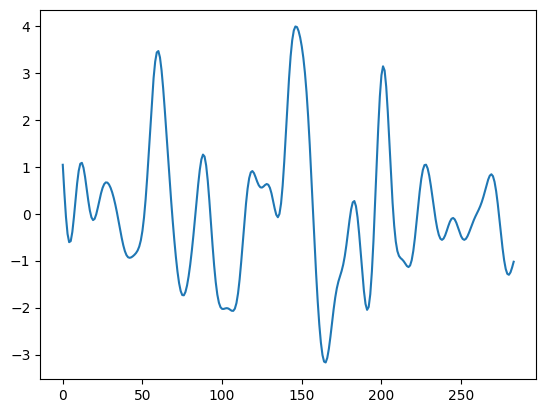

In [27]:
plt.plot(samples_punish[0,:])

In [41]:
def blocky_loss(data_loss, smoothness_loss, lambda_val=1):
    return data_loss + lambda_val * smoothness_loss

penalizing_function = combined_penalty  # assuming combined_penalty is defined elsewhere

def train_model_with_early_stopping(
    model, criterion, train_loader, validation_loader, optimizer, num_epochs, device, patience=5, lambda_val=0.01,
    alpha=alpha,beta=beta,lambda_tv=lambda_tv,lambda_const=lambda_const
):
    train_losses = []
    validation_losses = []
    best_validation_loss = float('inf')
    patience_counter = 0
    best_model_state = None  # ensure this is defined

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        last_predictions = None  # to store predictions from last batch of the epoch
        
        # Training loop
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            predictions = model(batch_x)

            # Shape check
            if predictions.shape != batch_y.shape:
                raise ValueError(
                    f"Shape mismatch: Predictions {predictions.shape} vs Targets {batch_y.shape}. "
                    "Ensure model output matches target dimensions."
                )

            loss_data = criterion(predictions, batch_y)
            smoothness_loss = penalizing_function(predictions,alpha=alpha,beta=beta,lambda_tv=lambda_tv,lambda_const=lambda_const)
            loss = blocky_loss(loss_data, smoothness_loss, lambda_val=lambda_val)
            total_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            last_predictions = predictions.detach()
            last_y = batch_y.detach()
            last_x = batch_x.detach()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

        # Plot one prediction per epoch (using the last batch predictions)
        if last_predictions is not None:
            plt.figure(figsize=(6, 4))
            # Assuming predictions: [batch, time, 1]
            plt.plot(last_x[0, :, 0].cpu().numpy(), label=f'Signal Epoch {epoch+1}',alpha=0.5)
            plt.plot(last_predictions[0, :, 0].cpu().numpy(), label=f'Prediction Epoch {epoch+1}')
            plt.plot(last_y[0, :, 0].cpu().numpy(), label=f'Target Epoch {epoch+1}')
            plt.title(f'Prediction at Epoch {epoch+1}')
            plt.xlabel('Time step')
            plt.ylabel('Prediction value')
            plt.legend()
            plt.grid(True)
            plt.show()

        # Validation phase
        model.eval()
        total_validation_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in validation_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                predictions = model(batch_x)
                loss_data = criterion(predictions, batch_y)
                smoothness_loss = penalizing_function(predictions)
                loss = blocky_loss(loss_data, smoothness_loss, lambda_val=lambda_val)
                total_validation_loss += loss.item()

        avg_validation_loss = total_validation_loss / len(validation_loader)
        validation_losses.append(avg_validation_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_validation_loss:.4f}")

        # Early stopping logic
        if (avg_validation_loss < best_validation_loss * 0.95): 
            best_validation_loss = avg_validation_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epoch(s).")
        
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

        # If you have a scheduler, define it outside and uncomment:
        # scheduler.step(avg_validation_loss)

    # Restore the best model weights if desired
    # model.load_state_dict(best_model_state)

    # Plot the train vs validation losses at the end
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.yscale('log') 
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_model_state


In [42]:
  
# Combined RNN-CNN Model
class RNNCNNDeconvolution(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size,output_dim=1):
        super(RNNCNNDeconvolution, self).__init__()
        self.kernel_rnn = KernelRNN(input_dim, hidden_dim, kernel_size)
        self.deconv_cnn = DeconvolutionCNN(kernel_size)
    def forward(self, y):
        kernel = self.kernel_rnn(y)  # Predict kernel with RNN
        x_hat = self.deconv_cnn(y, kernel)  # Deconvolve signal
        x_out = self.transformer(x_hat)
        return x_out  # Shape: [batch_size, timepoints, 1]

In [43]:
import torch.nn.functional as F
import pywt
# Hyperparameters
input_size = 1  # input is a single feature per voxel
hidden_size = 64
output_size = 1  # we predict one value per timeseries per voxel
num_epochs = 100
batch_size = 32
learning_rate = 0.0001
patience=15
lambda_val=1e-6
kernel_size=40
X_train_def.to(device)
Y_train_def.to(device)
X_val_def.to(device)
Y_val_def.to(device)

train_dataset = TensorDataset(X_train_def, Y_train_def)
validation_dataset = TensorDataset(X_val_def, Y_val_def)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

#model = RNNCNNDeconvolution(input_size, hidden_size, kernel_size).to(device)
model = RNNCNNDeconvolutionRNN(input_size, hidden_size, kernel_size).to(device)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

best_model_state = train_model_with_early_stopping(
    model, criterion, train_loader, validation_loader, optimizer, 
    num_epochs, device, patience=patience, lambda_val=lambda_val
)



KeyboardInterrupt: 

In [ ]:
print(torch.version.cuda,torch.version.__version__)

hints by chatgpt

1. Hidden Size and Layers: 
    
    Your model uses an LSTM with hidden_size = 128 and num_layers = 2. 
    This can be appropriate, but you could experiment with different values for the number of hidden units and layers.
    
    Increase Hidden Size: If the model is underfitting, try increasing the hidden_size (e.g., try 256 or 512).
    
    Number of Layers: You could experiment with more layers (e.g., num_layers=3), but be careful, as increasing the depth can also lead to overfitting or make training more difficult.




3. Overfitting Check and Regularization
    Your model seems to be doing well in terms of loss reduction, but there’s always the potential for overfitting, especially when the validation loss starts to plateau.

    Dropout: Adding dropout layers in your LSTM can help prevent overfitting. LSTM layers don't have inherent regularization, and dropout can make the model more generalizable.

    L2 Regularization: You can add weight decay to the Adam optimizer, which is a form of L2 regularization, to penalize large weights and prevent overfitting.


3. Gradient Clipping
    Gradient Exploding: LSTMs can suffer from exploding gradients, especially with long sequences or deep networks. To prevent this, you can apply gradient clipping to the optimizer to stabilize the training.



4. Loss Function
    Mean Squared Error Loss: You're using nn.MSELoss, which is standard for regression tasks. However, if your data contains outliers, MSE can be very sensitive. If that's the case, you could try using Huber Loss, which is more robust to outliers.


5. Increase Learning Rate or Use Scheduler:

   Try a slightly higher learning rate (e.g., 0.0005) or use a learning rate scheduler like ReduceLROnPlateau.

   scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

In [ ]:
model.load_state_dict(best_model_state)

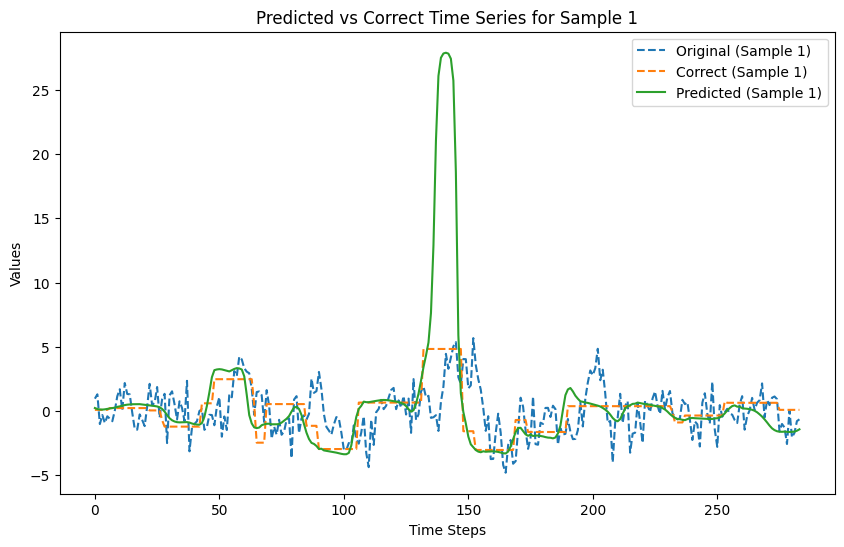

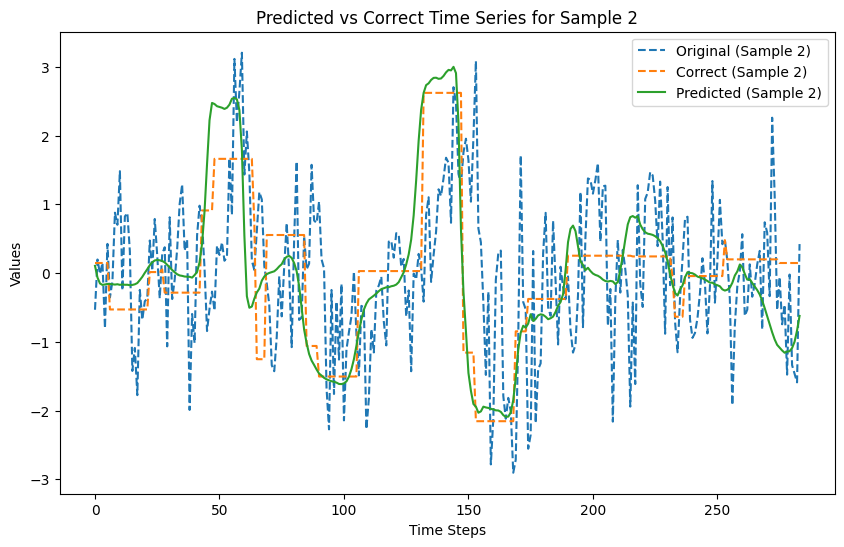

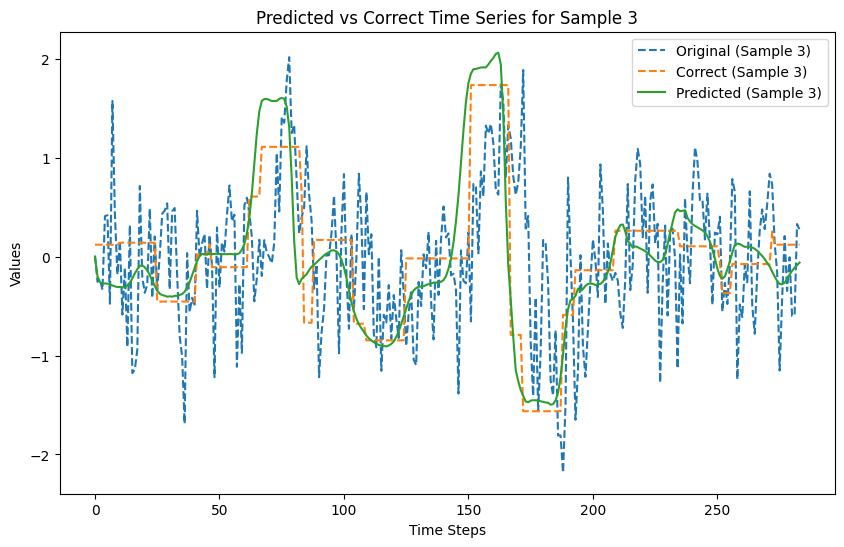

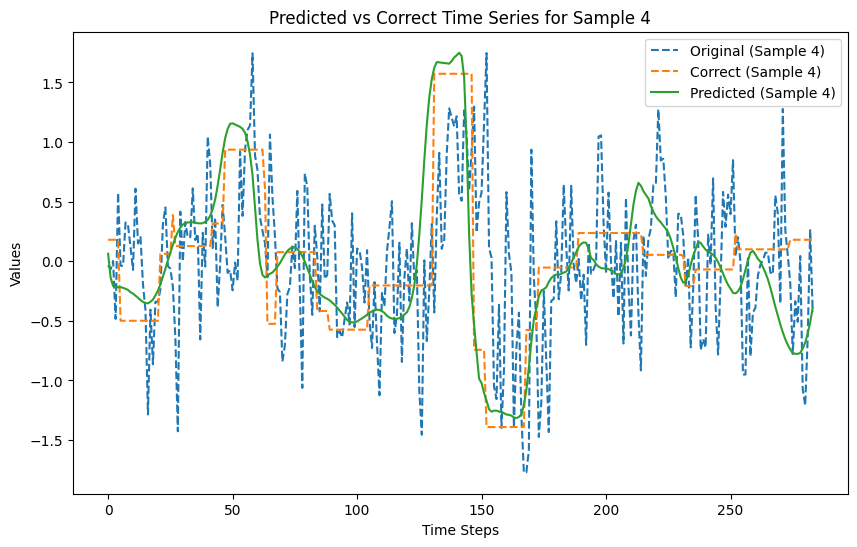

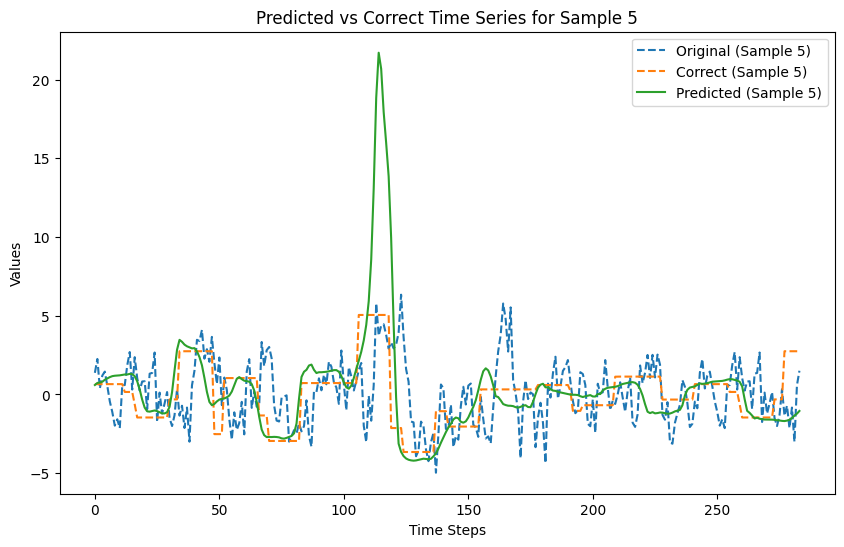

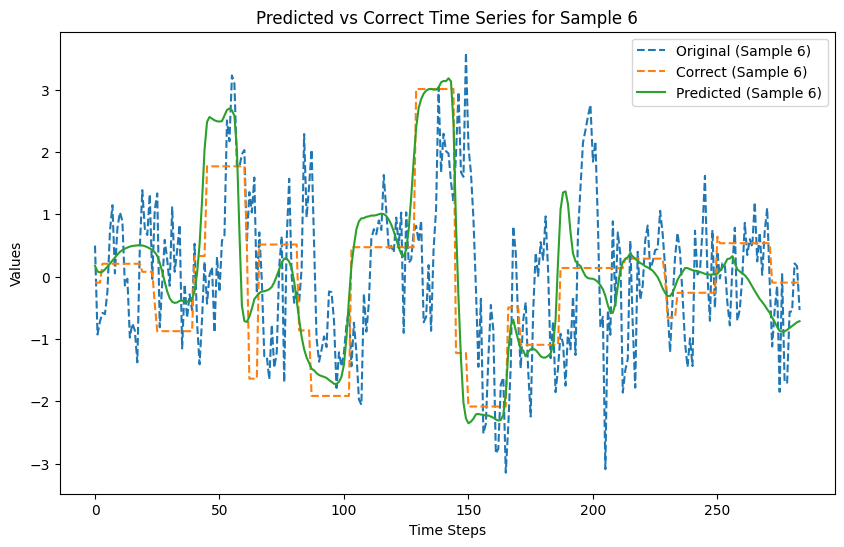

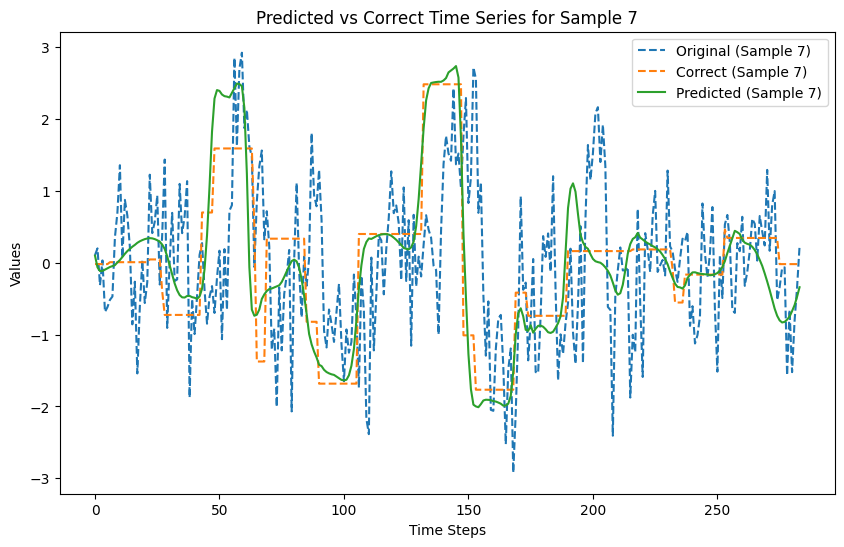

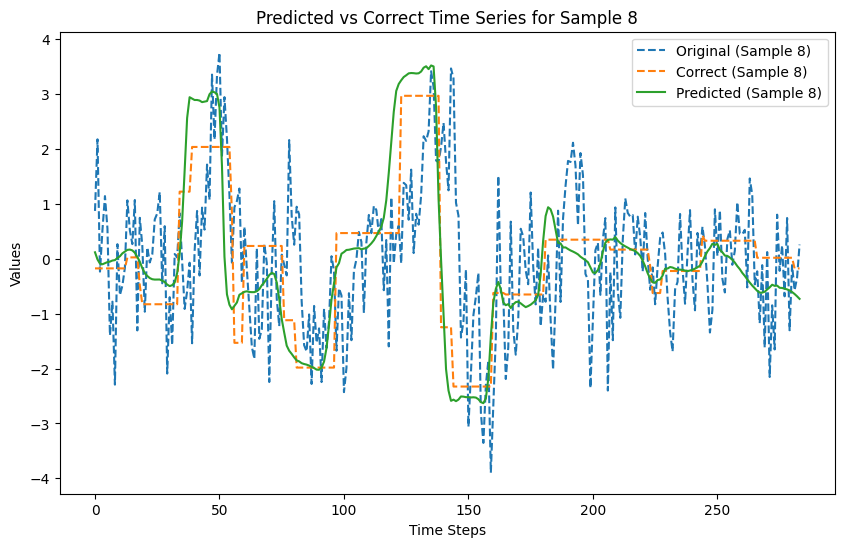

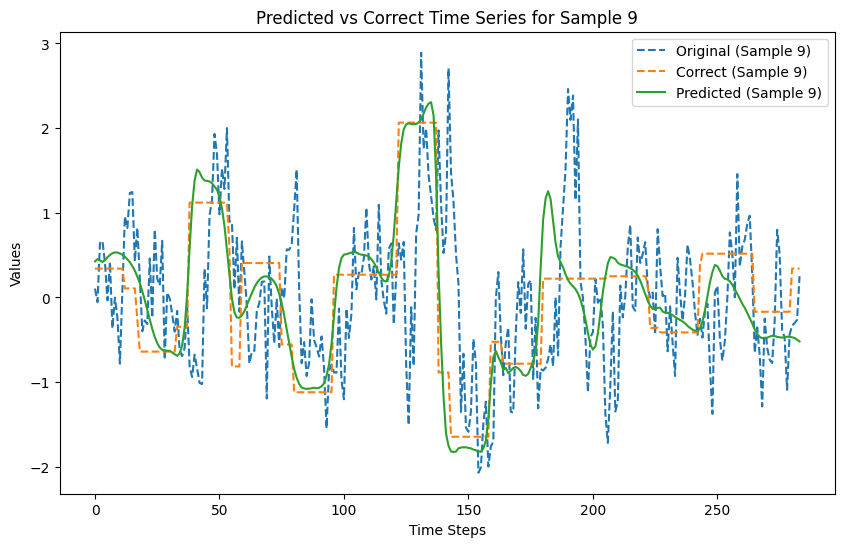

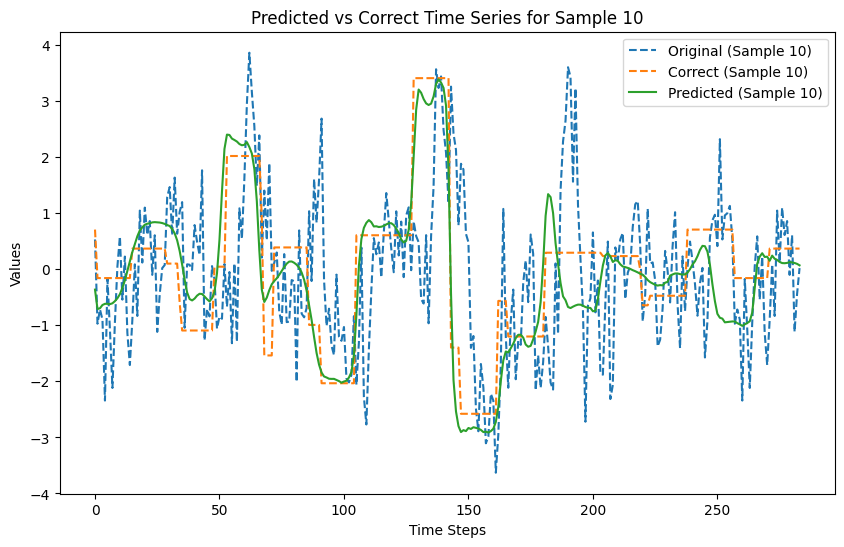

In [27]:
import matplotlib.pyplot as plt
# Assuming the model is already trained
model.eval()  # Set the model to evaluation mode

# Select one batch of test data from the loader
for X_sample, Y_sample in validation_loader:
    X_sample, Y_sample = X_sample.to(device), Y_sample.to(device)
    break  # Take the first batch

for i in range(10):
    X_sample_single = X_sample[i]
    Y_sample_single = Y_sample[i]

    # Get the prediction
    with torch.no_grad():
        Y_pred_single = model(X_sample_single.unsqueeze(0))  # Add batch dimension
        Y_pred_single = Y_pred_single.squeeze(0)  # Remove batch dimension

    # Convert to numpy for plotting
    Y_sample_single = Y_sample_single.cpu().numpy()
    Y_pred_single = Y_pred_single.cpu().numpy()
    X_sample_single= X_sample_single.cpu().numpy()
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(X_sample_single, label=f'Original (Sample {i+1})', linestyle='--')

    plt.plot(Y_sample_single, label=f'Correct (Sample {i+1})', linestyle='--')
    plt.plot(Y_pred_single, label=f'Predicted (Sample {i+1})', linestyle='-')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.title(f'Predicted vs Correct Time Series for Sample {i+1}')
    plt.legend()
    plt.show()

### New subjects

In [28]:
test_dataset = TensorDataset(X_test_def, Y_test_def)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

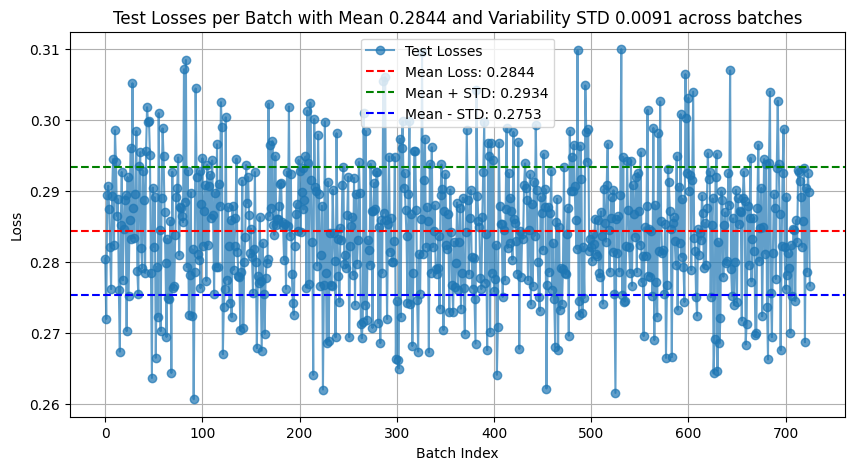

In [29]:
model.eval()
total_test_loss = 0
loss_list = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)
        #print(loss)
        total_test_loss += loss.item()
        loss_list.append(loss.item())

avg_test_loss = np.mean(loss_list)
std_test_loss = np.std(loss_list)

# Line plot of losses
plt.figure(figsize=(10, 5))
plt.plot(loss_list, marker='o', alpha=0.7, label='Test Losses')
plt.axhline(avg_test_loss, color='red', linestyle='--', label=f'Mean Loss: {avg_test_loss:.4f}')
plt.axhline(avg_test_loss + std_test_loss, color='green', linestyle='--', label=f'Mean + STD: {avg_test_loss + std_test_loss:.4f}')
plt.axhline(avg_test_loss - std_test_loss, color='blue', linestyle='--', label=f'Mean - STD: {avg_test_loss - std_test_loss:.4f}')
plt.xlabel('Batch Index')
plt.ylabel('Loss')
plt.title(f'Test Losses per Batch with Mean {avg_test_loss:.4f} and Variability STD {std_test_loss:.4f} across batches')
plt.legend()
plt.grid(True)
plt.show()

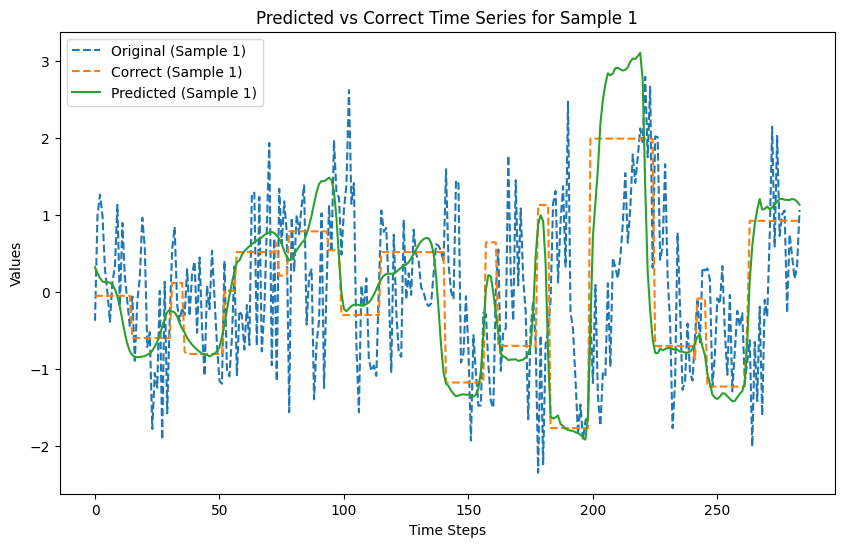

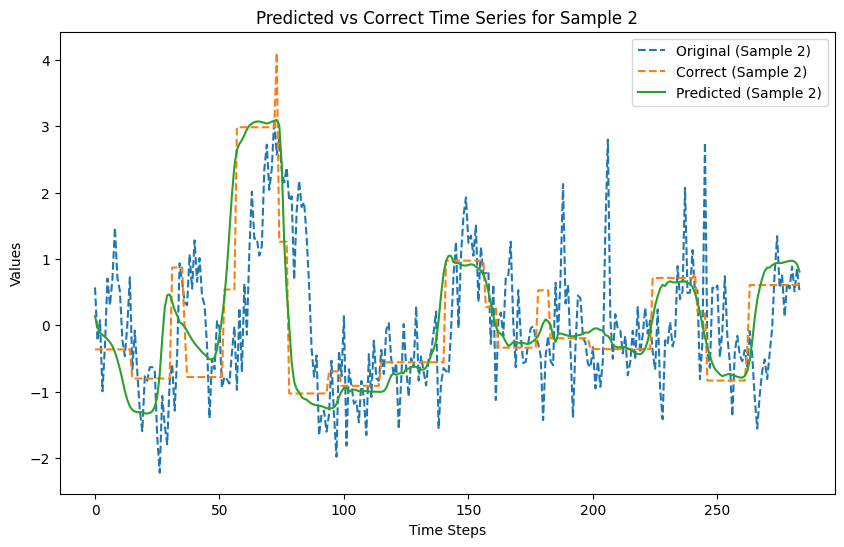

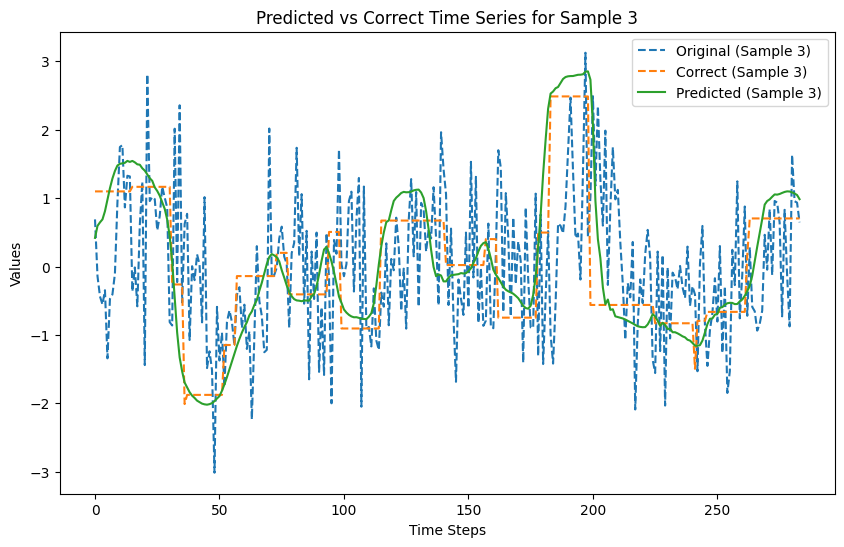

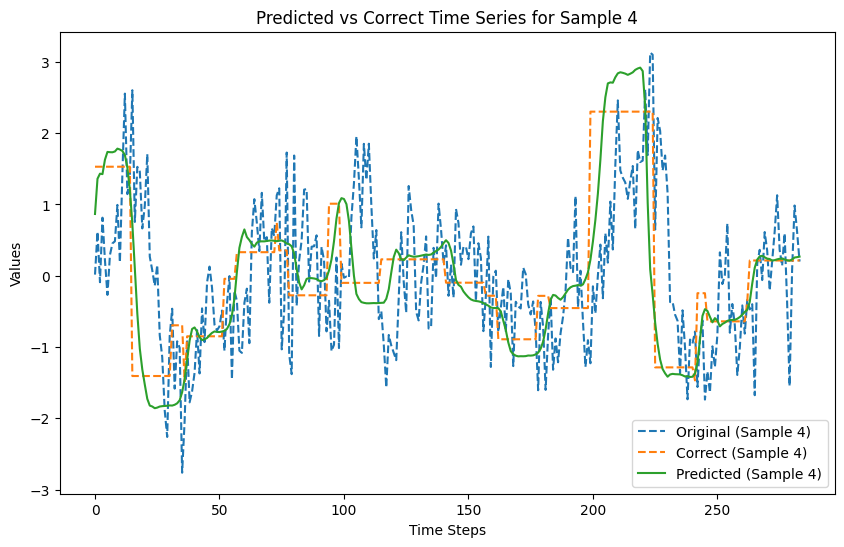

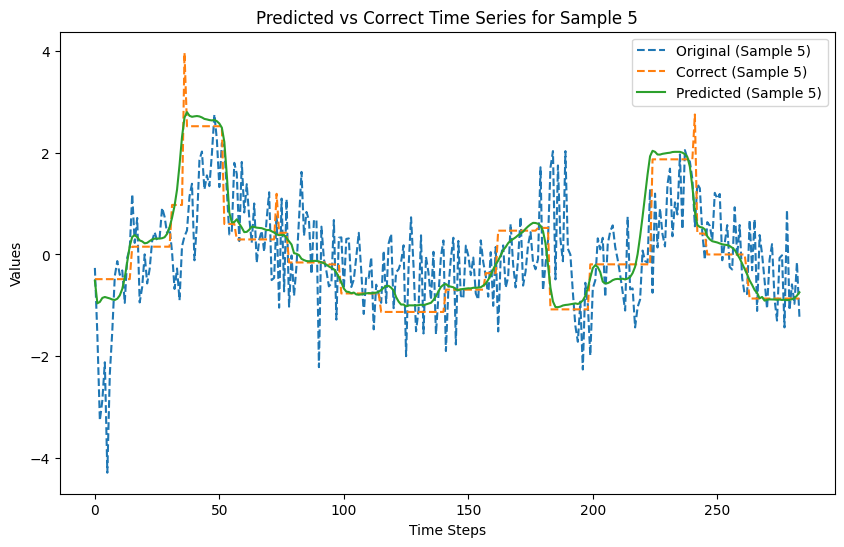

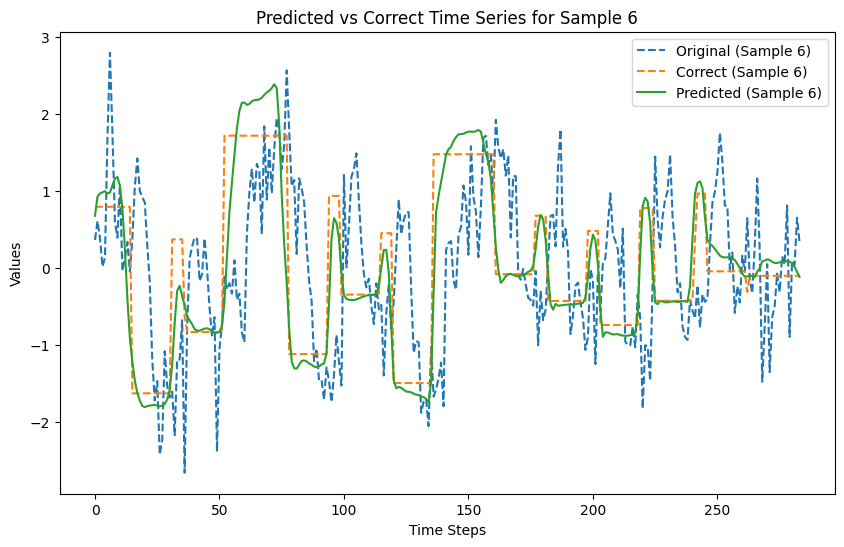

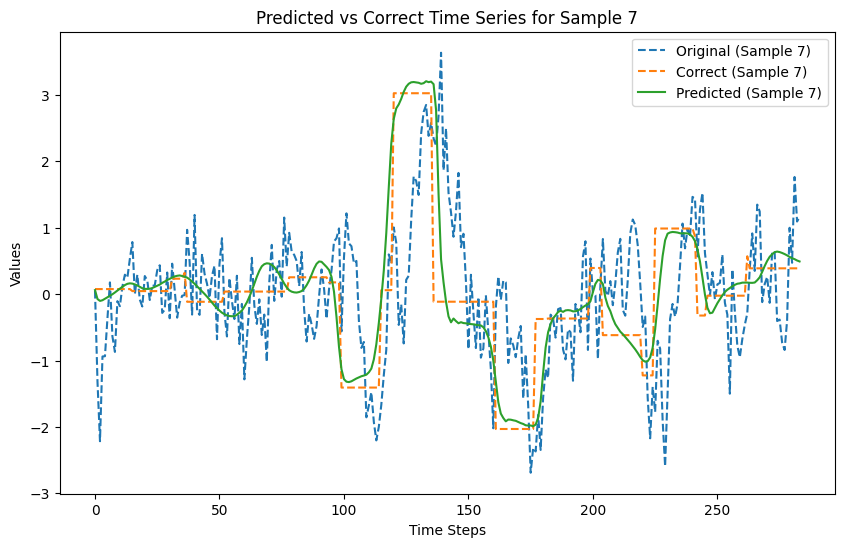

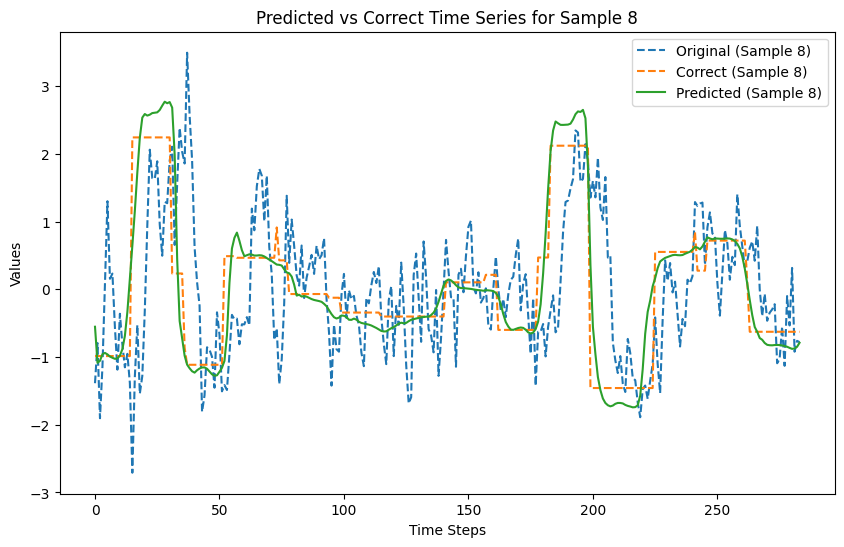

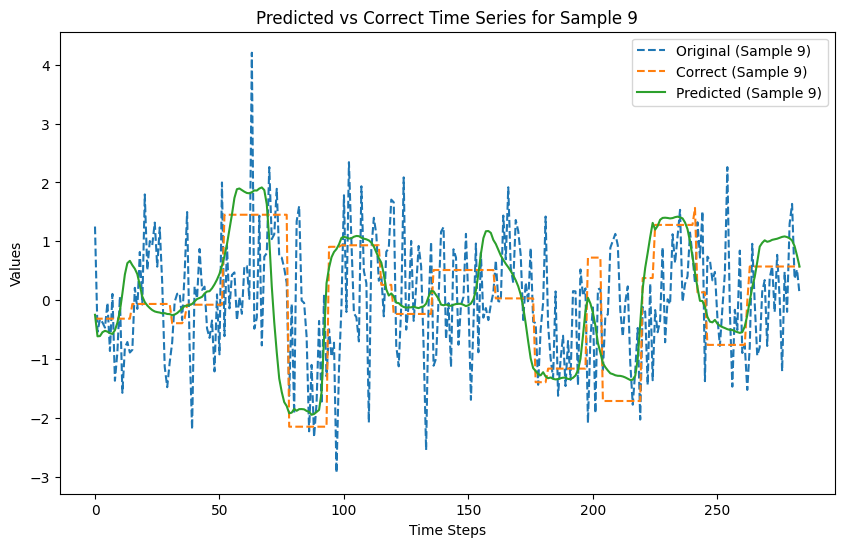

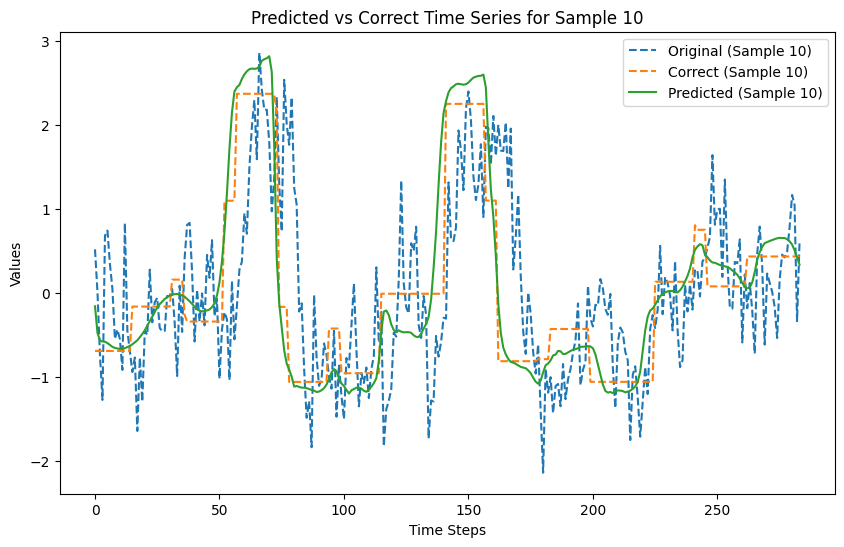

In [30]:
import matplotlib.pyplot as plt
# Assuming the model is already trained
model.eval()  # Set the model to evaluation mode

# Select one batch of test data from the loader
for X_sample, Y_sample in test_loader:
    X_sample, Y_sample = X_sample.to(device), Y_sample.to(device)
    break  # Take the first batch

for i in range(10):
    X_sample_single = X_sample[i]
    Y_sample_single = Y_sample[i]

    # Get the prediction
    with torch.no_grad():
        Y_pred_single = model(X_sample_single.unsqueeze(0))  # Add batch dimension
        Y_pred_single = Y_pred_single.squeeze(0)  # Remove batch dimension

    # Convert to numpy for plotting
    Y_sample_single = Y_sample_single.cpu().numpy()
    Y_pred_single = Y_pred_single.cpu().numpy()
    X_sample_single = X_sample_single.cpu().numpy()
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(X_sample_single, label=f'Original (Sample {i+1})', linestyle='--')

    plt.plot(Y_sample_single, label=f'Correct (Sample {i+1})', linestyle='--')
    plt.plot(Y_pred_single, label=f'Predicted (Sample {i+1})', linestyle='-')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.title(f'Predicted vs Correct Time Series for Sample {i+1}')
    plt.legend()
    plt.show()

### Impulse, block and step response

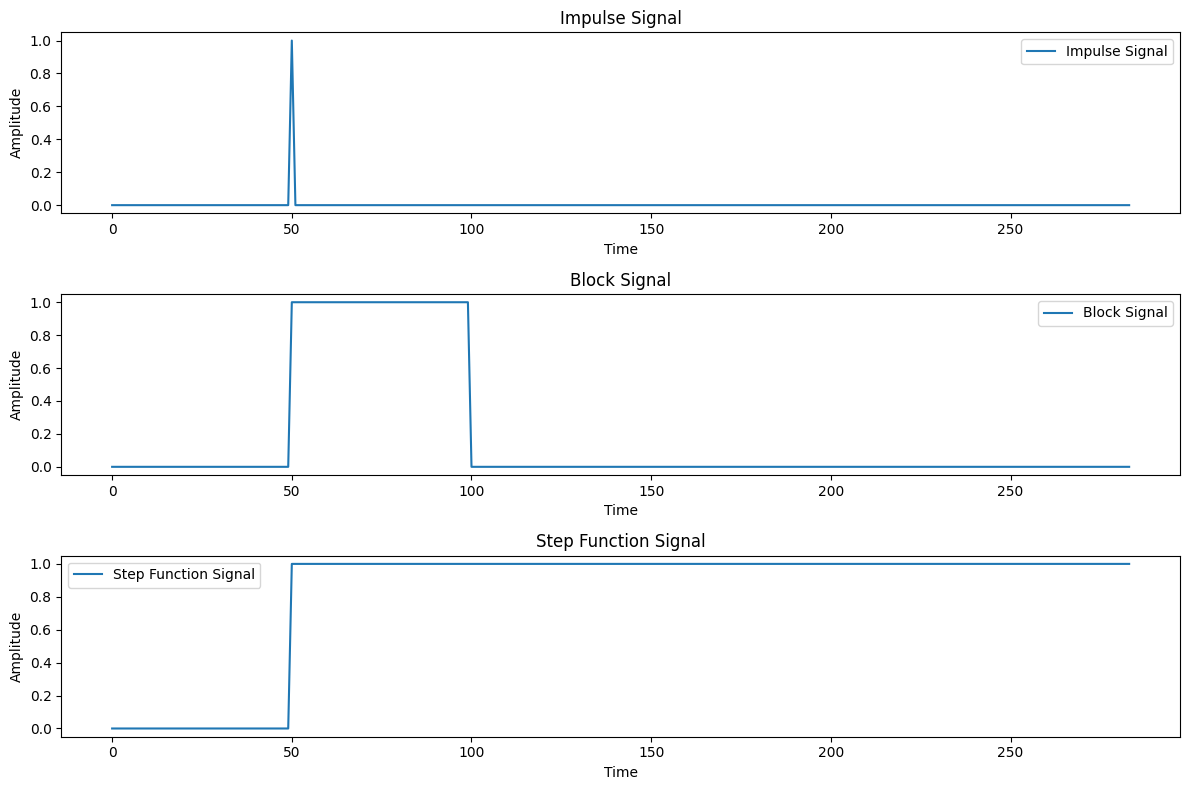

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define the number of samples and timepoints
n_timepoints = 284

# Create impulse signals
impulse_positions = [50, 100, 150, 200, 250]  # positions for impulse signals (example)
impulse_tensor = torch.zeros((len(impulse_positions), n_timepoints, 1)).cpu()  # [n_samples, 284, 1]

# Set impulse signals to 1 at specified positions
for i in range(len(impulse_positions)):
    pos = impulse_positions[i]
    impulse_tensor[i, pos, 0] = 1

# Create block signals (constant signal for a block of timepoints)
block_tensor = torch.zeros((1, n_timepoints, 1)).cpu()  # [n_samples, 284, 1]
block_start = 50  # Start of the block
block_end = 100  # End of the block

# Set block signals to 1 between block_start and block_end
block_tensor[0, block_start:block_end, 0] = 1

# Create step function signals (start at 0, jump to 1 after a specific timepoint)
step_positions = [50,100,150,200]  # Timepoint where step function jumps

step_tensor = torch.zeros((len(step_positions), n_timepoints, 1)).cpu()  # [n_samples, 284, 1]

# Set step function to 1 after step_position
for i in range(len(step_positions)):
    step_position = step_positions[i]
    step_tensor[i, step_position:, 0] = 1

# Plot the first sample from each signal
plt.figure(figsize=(12, 8))

# Plot Impulse Signal
plt.subplot(3, 1, 1)
plt.plot(impulse_tensor[0, :, 0].numpy(), label="Impulse Signal")
plt.title("Impulse Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()

# Plot Block Signal
plt.subplot(3, 1, 2)
plt.plot(block_tensor[0, :, 0].numpy(), label="Block Signal")
plt.title("Block Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()

# Plot Step Function Signal
plt.subplot(3, 1, 3)
plt.plot(step_tensor[0, :, 0].numpy(), label="Step Function Signal")
plt.title("Step Function Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()


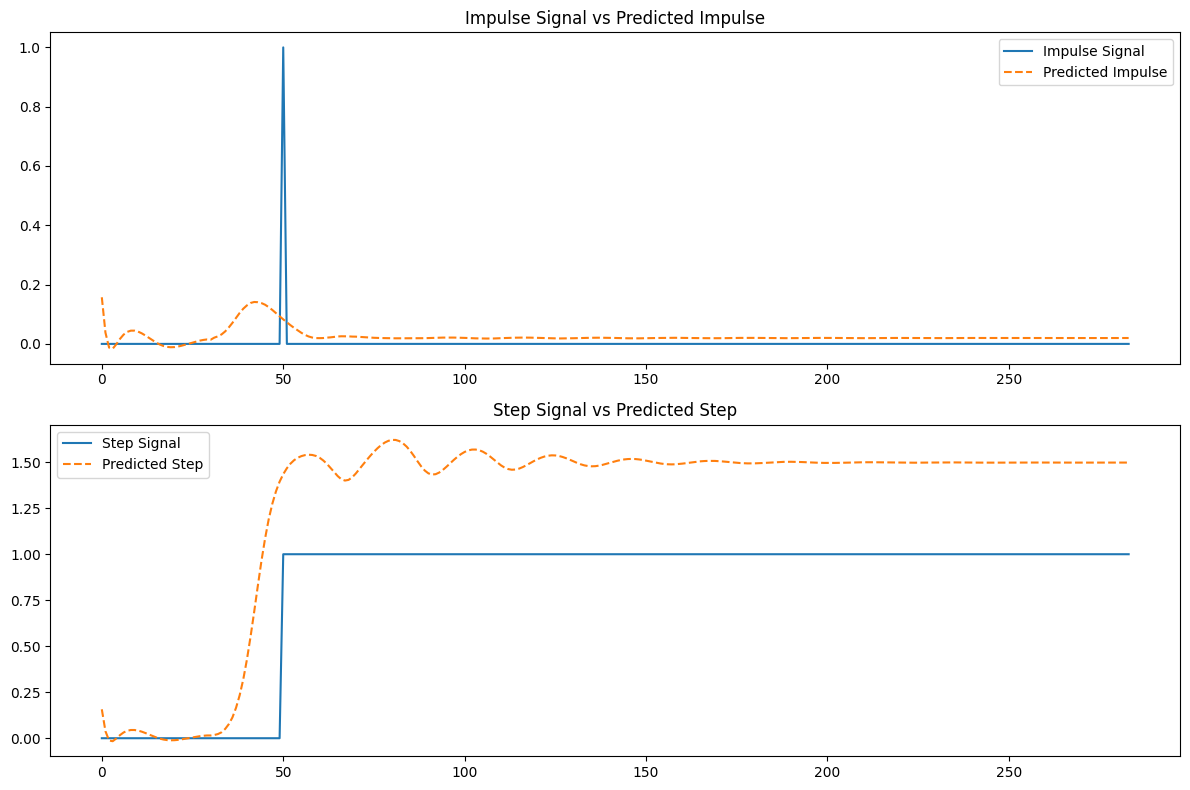

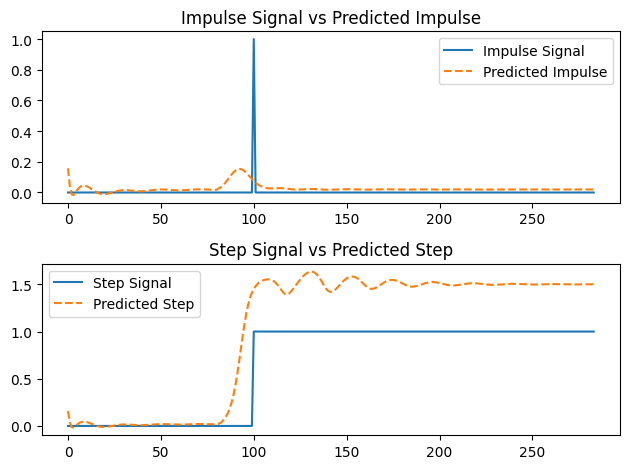

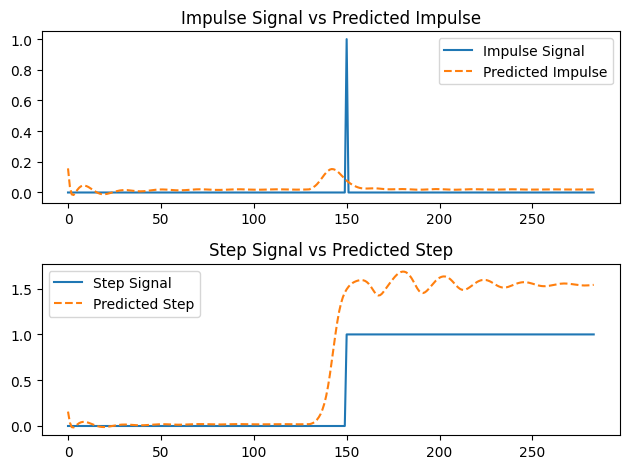

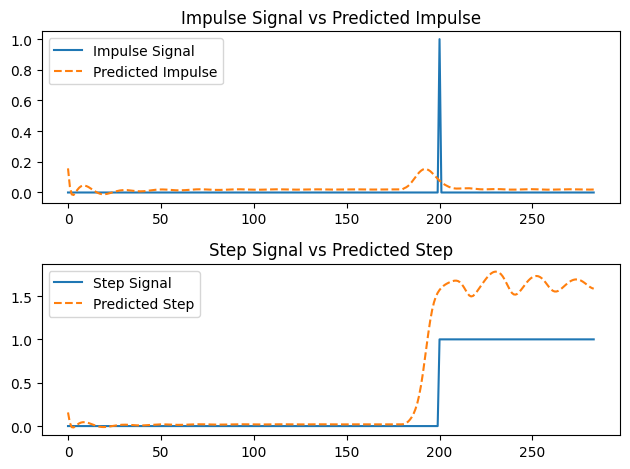

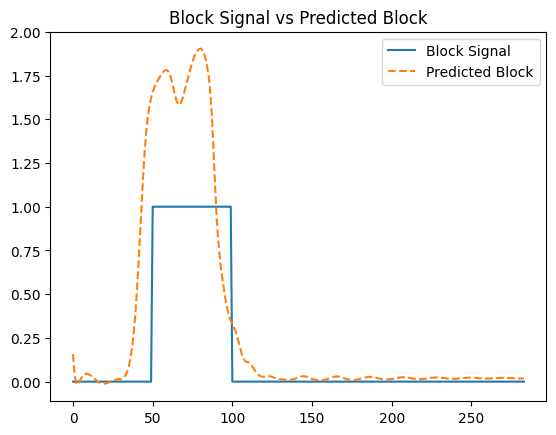

In [32]:
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()

# Disable gradient calculation for inference
with torch.no_grad():
    # Run the impulse, step, and block signals through the model
    impulse_pred = model(impulse_tensor.to(device)).cpu().numpy()
    step_pred = model(step_tensor.to(device)).cpu().numpy()
    block_pred = model(block_tensor.to(device)).cpu().numpy()

# Plotting the results
plt.figure(figsize=(12, 8))
for i in range(4):
    # Plot Impulse Signal and Prediction
    plt.subplot(2, 1, 1)
    plt.plot(impulse_tensor.cpu().numpy()[i], label='Impulse Signal')
    plt.plot(impulse_pred[i], label='Predicted Impulse', linestyle='--')
    plt.title("Impulse Signal vs Predicted Impulse")
    plt.legend()

    # Plot Step Signal and Prediction
    plt.subplot(2, 1, 2)
    plt.plot(step_tensor.cpu().numpy()[i], label='Step Signal')
    plt.plot(step_pred[i], label='Predicted Step', linestyle='--')
    plt.title("Step Signal vs Predicted Step")
    plt.legend()

    # Plot Block Signal and Prediction

    plt.tight_layout()
    plt.show()
plt.plot(block_tensor.cpu().numpy().flatten(), label='Block Signal')
plt.plot(block_pred.flatten(), label='Predicted Block', linestyle='--')
plt.title("Block Signal vs Predicted Block")
plt.legend()
plt.show()

(84,) (44,)


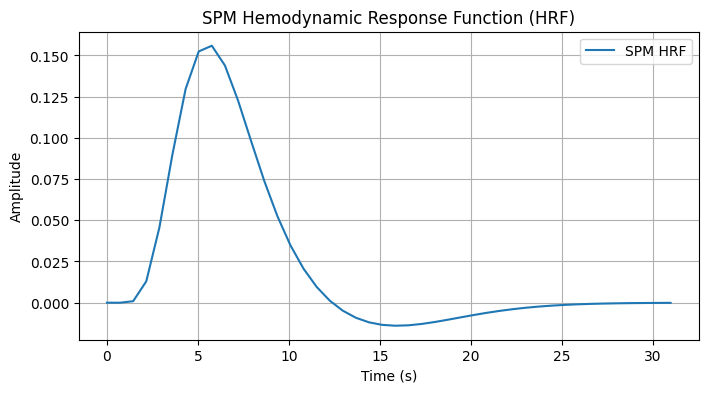

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.glm.first_level import spm_hrf

# Parameters
TR = 0.72  # Repetition time in seconds
frame_times = np.arange(0, 60, TR)  # Time points for 32 seconds at the given TR

# Compute the SPM HRF with matching sampling
hrf = spm_hrf(tr=TR, oversampling=1)  # Set oversampling=1 to match the TR
print(frame_times.shape,hrf.shape)
# Plot the HRF
plt.figure(figsize=(8, 4))
plt.plot(frame_times[:len(hrf[:])], hrf, label='SPM HRF')  # Match lengths
plt.title('SPM Hemodynamic Response Function (HRF)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()


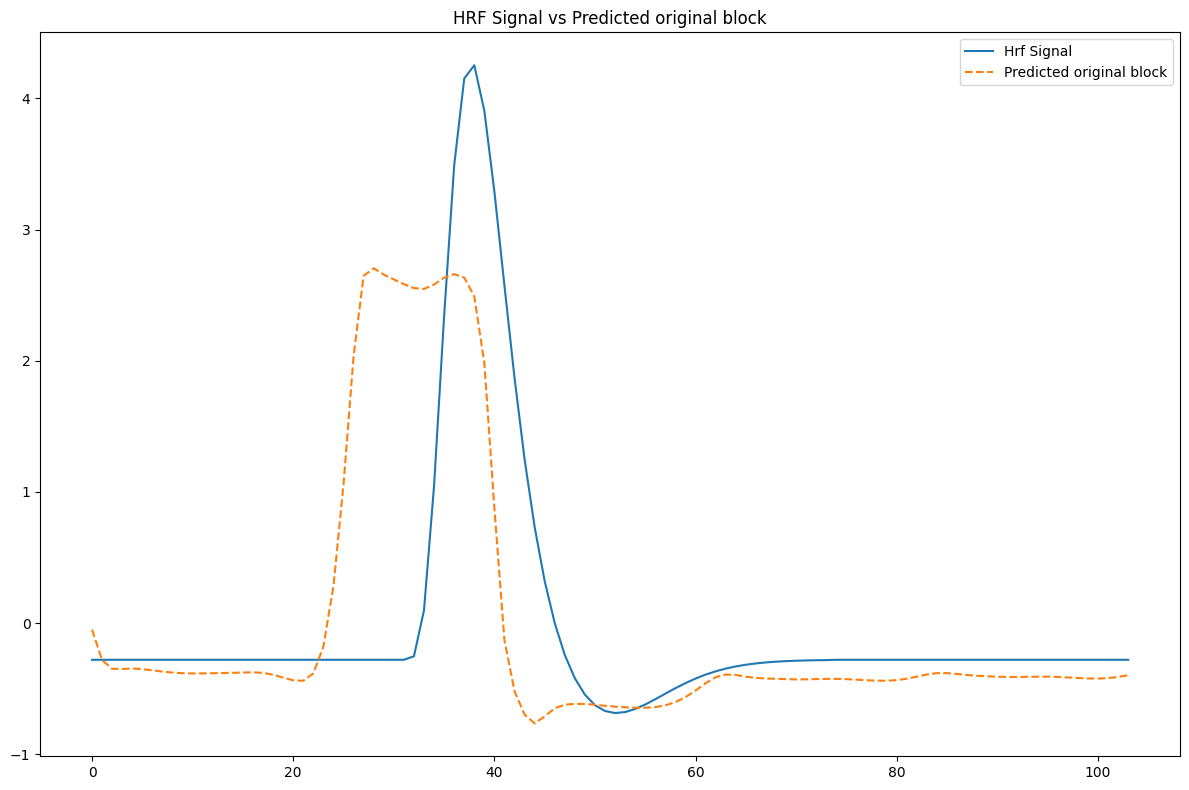

In [34]:
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()
hrf_tensor=torch.tensor(hrf,dtype=torch.float32).unsqueeze(-1).unsqueeze(0)
hrf_tensor=F.pad(hrf_tensor,(0,0,30,30), mode='constant', value=0)
hrf_tensor= (hrf_tensor-torch.mean(hrf_tensor,dim=1))/torch.std(hrf_tensor,dim=1)

# Disable gradient calculation for inference
with torch.no_grad():
    # Run the impulse, step, and block signals through the model
    hrf_pred = model(hrf_tensor.to(device)).cpu().numpy()

# Plotting the results
plt.figure(figsize=(12, 8))
# Plot Impulse Signal and Prediction
plt.plot(hrf_tensor.cpu().numpy()[0], label='Hrf Signal')
plt.plot(hrf_pred[0], label='Predicted original block', linestyle='--')
plt.title("HRF Signal vs Predicted original block")
plt.legend()

plt.tight_layout()
plt.show()


In [70]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"model_{timestamp}.pth"

torch.save(model.state_dict(), filename)
print(f"Model saved as {filename}")

Model saved as model_20241211_105413.pth


In [33]:
merged.subject

<xarray.DataArray 'subject' (voxel_subj: 13573)> Size: 489kB
array(['127630_LR', '127630_LR', '127630_LR', ..., '127630_LR', '127630_LR',
       '127630_LR'], dtype='<U9')
Coordinates:
    task        (voxel_subj) <U10 543kB 'LANGUAGE' 'LANGUAGE' ... 'RELATIONAL'
  * voxel_subj  (voxel_subj) object 109kB MultiIndex
  * subject     (voxel_subj) <U9 489kB '127630_LR' '127630_LR' ... '127630_LR'
  * voxel       (voxel_subj) int64 109kB 0 1 2 3 4 ... 1934 1935 1936 1937 1938

In [71]:
tasks_127630_LR=merged.sel(subject="127630_LR")


In [72]:
tasks_127630_LR.task

<xarray.DataArray 'task' (voxel: 7756)> Size: 310kB
array(['LANGUAGE', 'LANGUAGE', 'LANGUAGE', ..., 'RELATIONAL',
       'RELATIONAL', 'RELATIONAL'], dtype='<U10')
Coordinates:
    task     (voxel) <U10 310kB 'LANGUAGE' 'LANGUAGE' ... 'RELATIONAL'
  * voxel    (voxel) int64 62kB 0 1 2 3 4 5 6 ... 1933 1934 1935 1936 1937 1938
    subject  <U9 36B '127630_LR'

In [73]:
def custom_progress_bar(current, total, description="Processing"):
    percent = int((current / total) * 100)
    bar = f"[{'#' * (percent // 2)}{'-' * (50 - percent // 2)}] {percent}%"
    sys.stdout.write(f"\r{description}: {bar}")
    sys.stdout.flush()
def concat_data_mod(all_X_train, all_Y_train):
    """
    Concatenate the data from all subjects into one large dataset.

    Parameters:
    - all_X_train: List of tensors, each containing training data for a subject.
    - all_Y_train: List of tensors, each containing labels for a subject.

    Returns:
    - Concatenated tensors for training, validation, and test sets.
    """

    # Concatenate lists into tensors
    X_train_def = torch.cat(all_X_train, dim=0).unsqueeze(-1)
    Y_train_def = torch.cat(all_Y_train, dim=0).unsqueeze(-1)

    return X_train_def,  Y_train_def

def get_data_tensors_mod(subject_ids):

    all_X_train, all_X_val, all_X_test = [], [], []
    all_Y_train, all_Y_val, all_Y_test = [], [], []
    print("\nProcessing Train Subjects:")

    # Process train subjects
    for idx, train_subj in enumerate(subject_ids, 1):
        subject_data = dataset.sel(subject=train_subj)  # Extract subject data
        X_train_tensor, Y_train_tensor = preprocess_subject_data(subject_data)
        # Augment training data
        # Apply temporal scaling to the augmented data
        all_X_train.append(X_train_tensor)
        all_Y_train.append(Y_train_tensor)
        custom_progress_bar(idx, len(subject_ids))



    # Concatenate data for all subjects
    X_train_def, Y_train_def= concat_data_mod(
        all_X_train,all_Y_train)
    print()
    print("X_train",X_train_def.shape)
    print("Y_train",Y_train_def.shape)

    return X_train_def, Y_train_def


In [74]:
subjects_ids = dataset.subject.values

X_tasks, Y_tasks = get_data_tensors_mod(subjects_ids)
print(X_tasks.shape,Y_tasks.shape)


Processing Train Subjects:
Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Processing: [--------------------------------------------------] 1%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Processing: [#-------------------------------------------------] 3%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Processing: [##------------------------------------------------] 5%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Processing: [###-----------------------------------------------] 6%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Processing: [####----------------------------------------------] 8%Data preprocess
Remove rows with NaNs in any voxel time s

Convert to PyTorch tensors
Processing: [#####################################-------------] 75%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Processing: [######################################------------] 76%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Processing: [#######################################-----------] 78%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Processing: [########################################----------] 80%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Processing: [########################################----------] 81%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Processing: [########################################

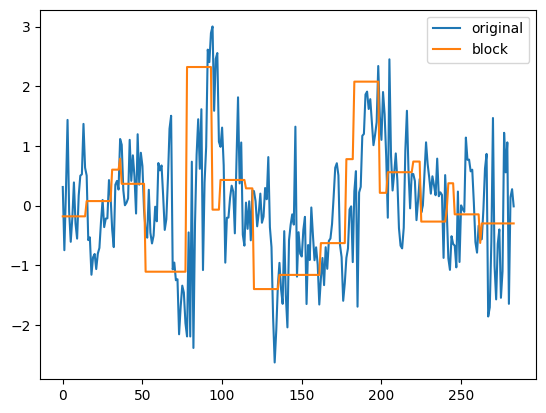

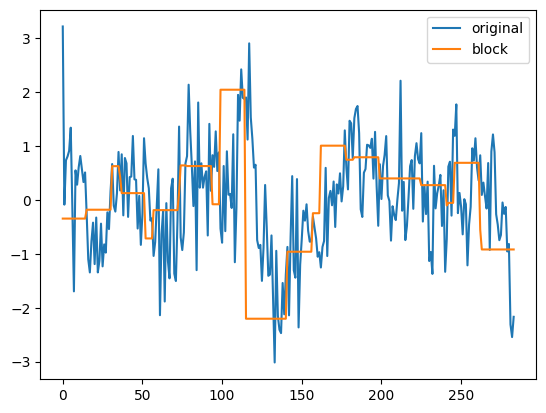

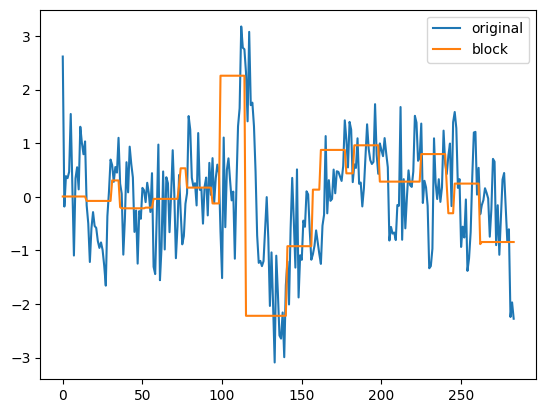

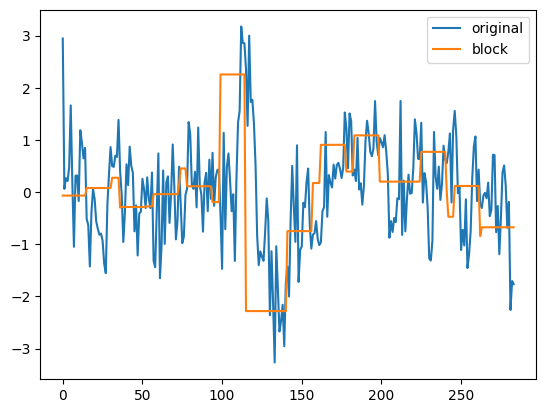

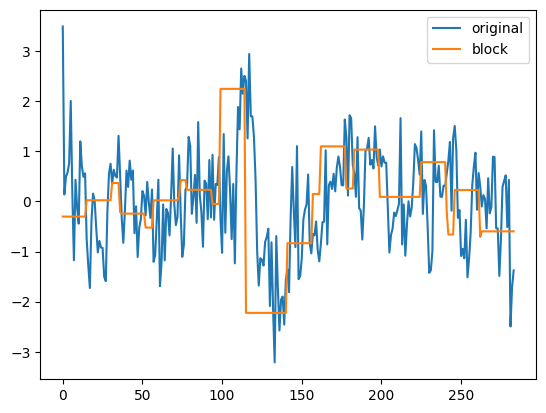

In [75]:

for i in range (5):
    x,y = X_tasks[-i,:],Y_tasks[-i,:]
    plt.plot(x,label="original")
    plt.plot(y,label='block')
    plt.legend()
    plt.show()

In [76]:
task_dataset = TensorDataset(X_tasks, Y_tasks)
task_loader = DataLoader(task_dataset, batch_size=batch_size, shuffle=True)


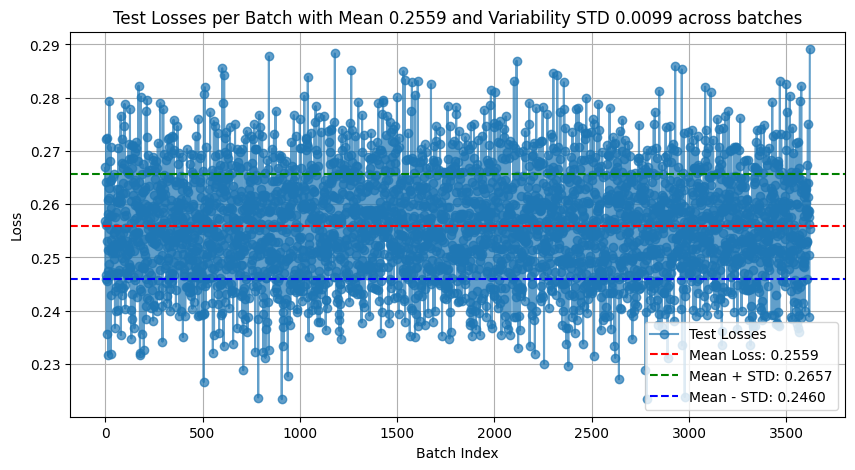

In [77]:
model.eval()
total_test_loss = 0
loss_list = []
with torch.no_grad():
    for batch_x, batch_y in task_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)
        #print(loss)
        total_test_loss += loss.item()
        loss_list.append(loss.item())

avg_test_loss = np.mean(loss_list)
std_test_loss = np.std(loss_list)

# Line plot of losses
plt.figure(figsize=(10, 5))
plt.plot(loss_list, marker='o', alpha=0.7, label='Test Losses')
plt.axhline(avg_test_loss, color='red', linestyle='--', label=f'Mean Loss: {avg_test_loss:.4f}')
plt.axhline(avg_test_loss + std_test_loss, color='green', linestyle='--', label=f'Mean + STD: {avg_test_loss + std_test_loss:.4f}')
plt.axhline(avg_test_loss - std_test_loss, color='blue', linestyle='--', label=f'Mean - STD: {avg_test_loss - std_test_loss:.4f}')
plt.xlabel('Batch Index')
plt.ylabel('Loss')
plt.title(f'Test Losses per Batch with Mean {avg_test_loss:.4f} and Variability STD {std_test_loss:.4f} across batches')
plt.legend()
plt.grid(True)
plt.show()

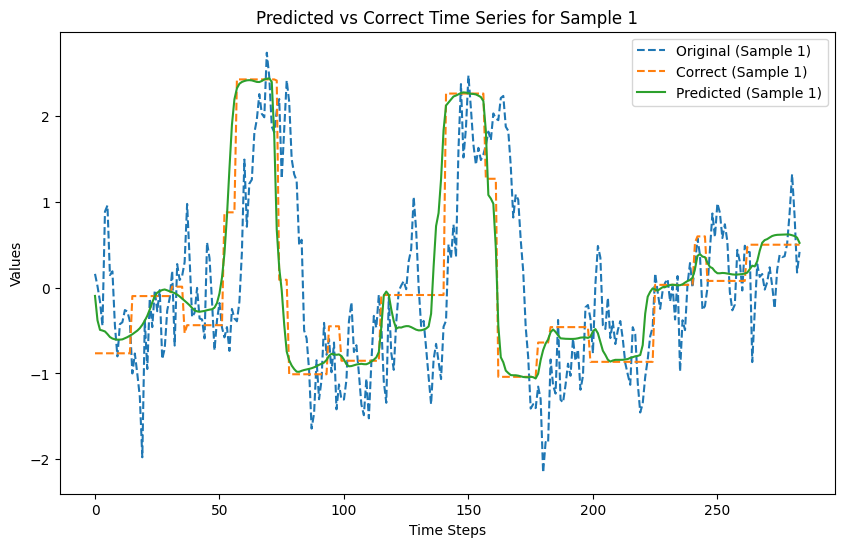

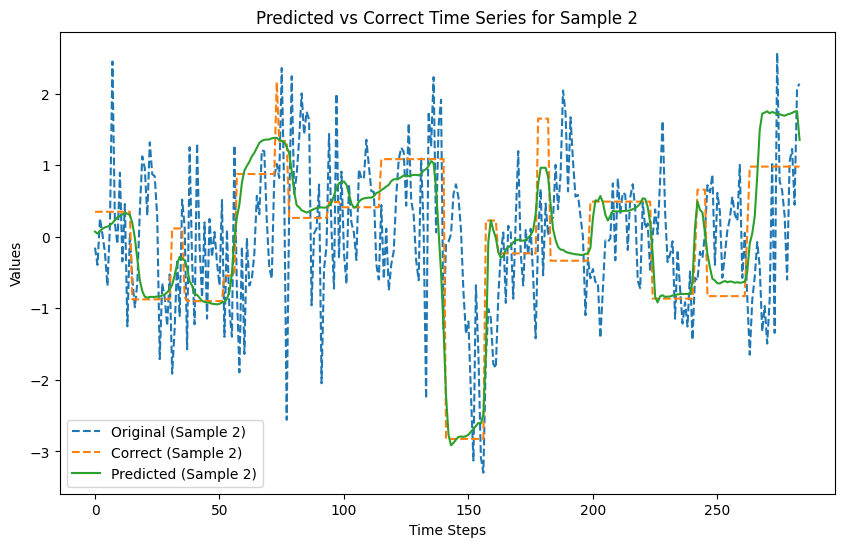

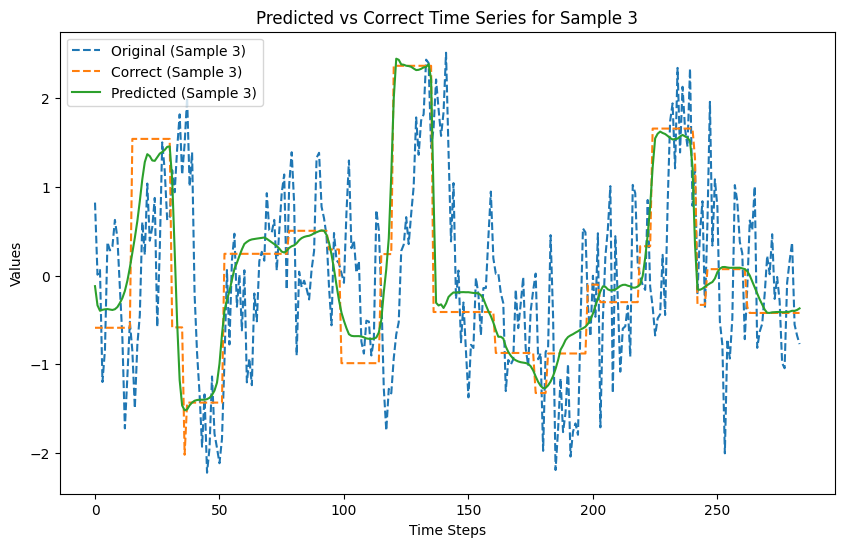

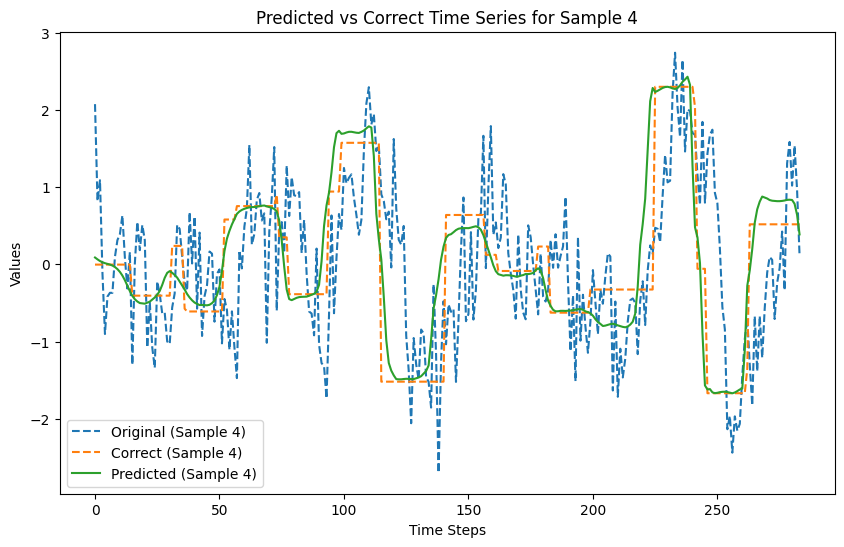

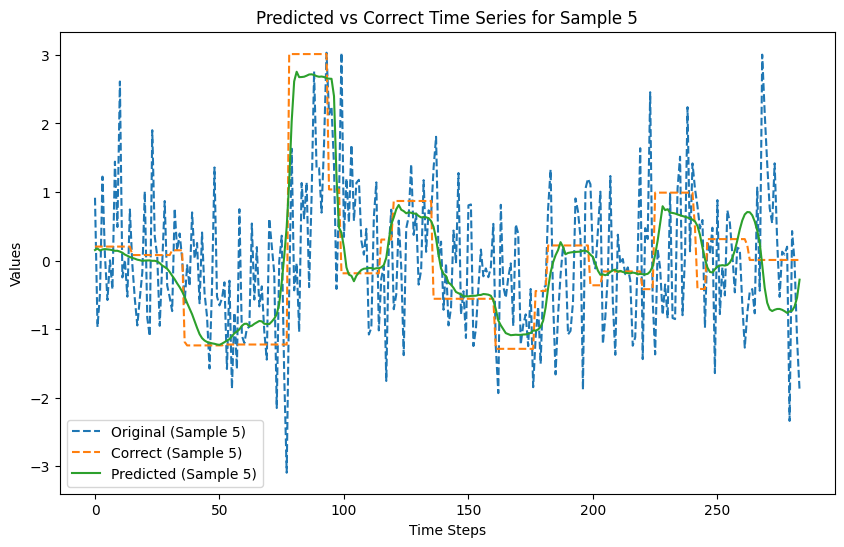

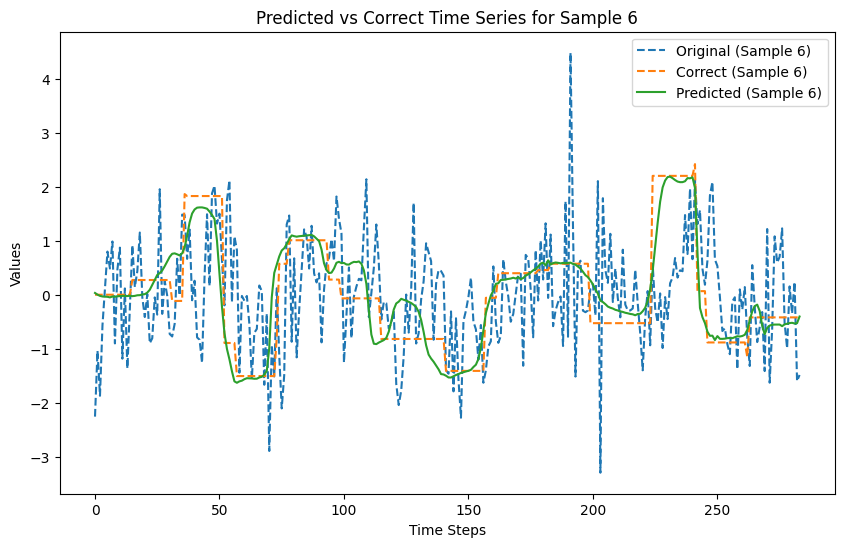

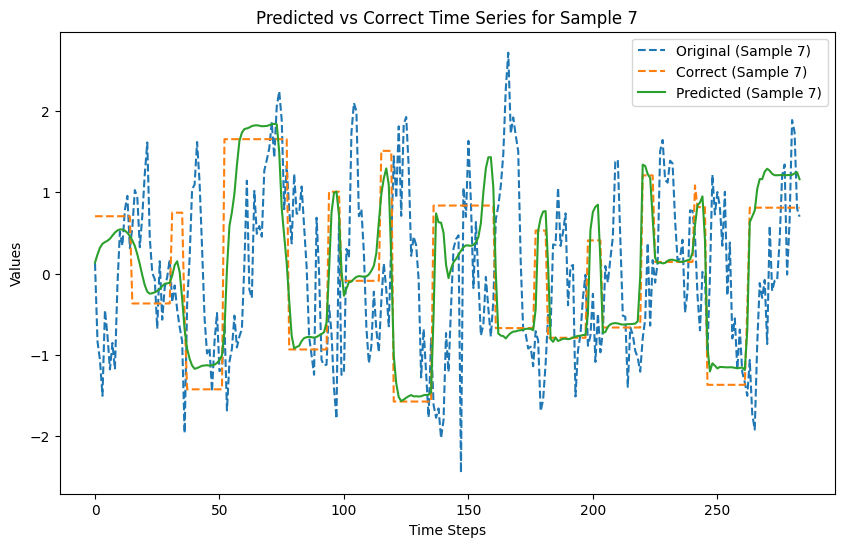

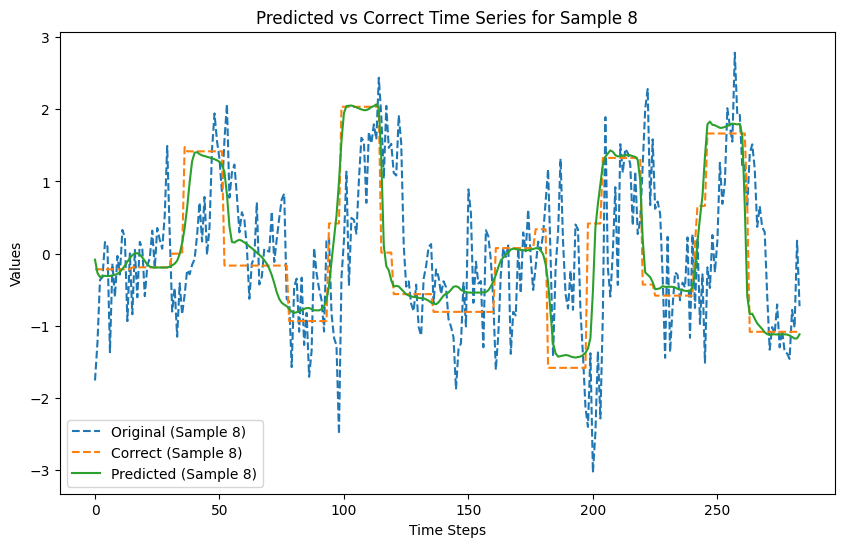

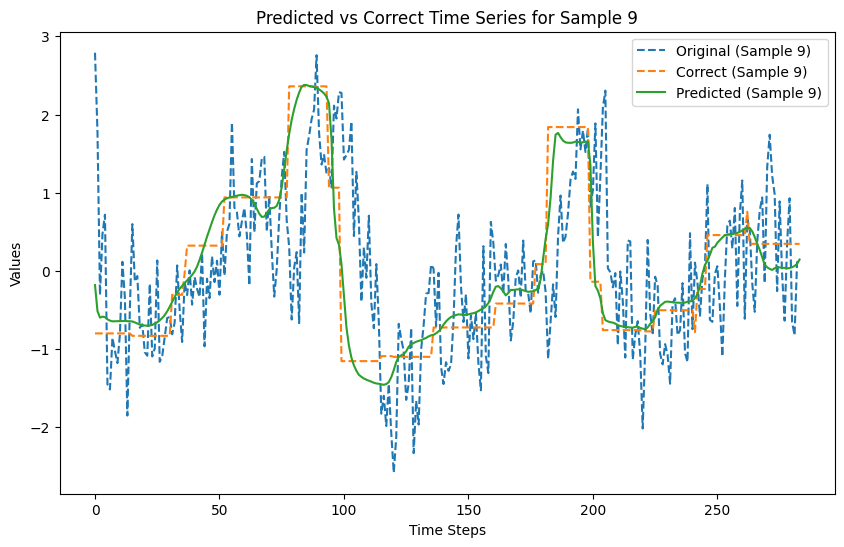

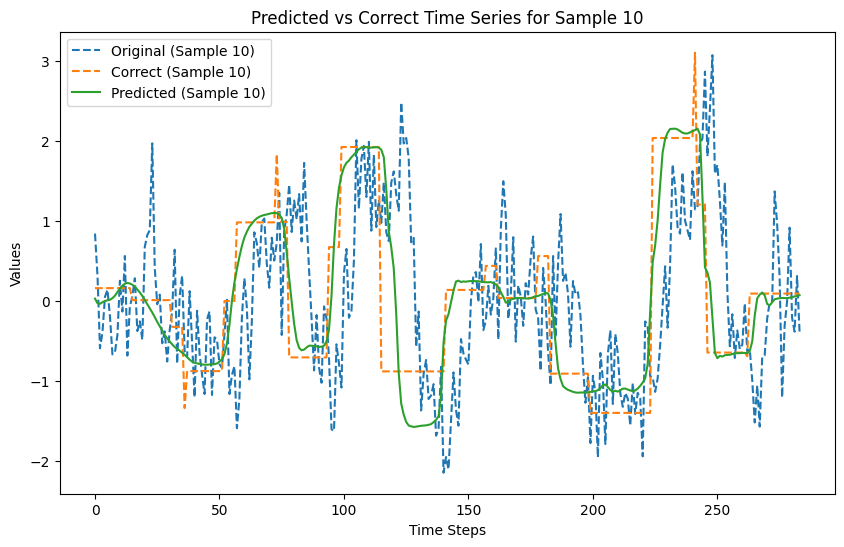

In [78]:
import matplotlib.pyplot as plt
# Assuming the model is already trained
model.eval()  # Set the model to evaluation mode

# Select one batch of test data from the loader
for X_sample, Y_sample in task_loader:
    X_sample, Y_sample = X_sample.to(device), Y_sample.to(device)
    break  # Take the first batch

for i in range(10):
    X_sample_single = X_sample[i]
    Y_sample_single = Y_sample[i]

    # Get the prediction
    with torch.no_grad():
        Y_pred_single = model(X_sample_single.unsqueeze(0))  # Add batch dimension
        Y_pred_single = Y_pred_single.squeeze(0)  # Remove batch dimension

    # Convert to numpy for plotting
    Y_sample_single = Y_sample_single.cpu().numpy()
    Y_pred_single = Y_pred_single.cpu().numpy()
    X_sample_single = X_sample_single.cpu().numpy()
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(X_sample_single, label=f'Original (Sample {i+1})', linestyle='--')

    plt.plot(Y_sample_single, label=f'Correct (Sample {i+1})', linestyle='--')
    plt.plot(Y_pred_single, label=f'Predicted (Sample {i+1})', linestyle='-')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.title(f'Predicted vs Correct Time Series for Sample {i+1}')
    plt.legend()
    plt.show()